In [1]:
%pylab
%matplotlib inline

import h5py
import pandas as pd
import os
import gc

#import plotly.express as px
from sklearn.preprocessing import MinMaxScaler,Normalizer,RobustScaler

import Helper_Basic as hbasic
hbasic.set_plot_prop()
plt.ion()

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


# Requirement for this script :

## Inputs :
1) H5/csv file with the mechanical data

2) AE catalog (csv) potentially with co-located mechanical data 

## Outputs :

1) Aligned, uniformally spaced, and time aggregated mechanical and AE rate/strain rate/work rate time series 

2) AE event catalog with data appended from the mechanical datasets (e.g. strain rate etc)

# Datafile with the raw deformation datasets & synchronised AE datasets 

a) Specify the path where the mechanical data is stored (in a h5 file)

b) Specify path to the AE data

In [2]:
path_data_folder = '../00_Data/Wet_Basalt/'
path_mechanical_data = path_data_folder+'wet_mechdata.csv'
path_AE_data = path_data_folder+'wet_events_with_mechdata.csv'
name_exp = 'Wet_Basalt'

## Location where the time series data (aggregated) is saved
path_to_save_out_time_series = '/home/tmittal/Causality/Basalt_Data/dataforcausalitytests_' 


### Loading the Mechanical Data

In [3]:
data_def = pd.read_csv(path_mechanical_data)
data_def['date'] = pd.to_datetime(data_def['t_def'])
data_def['time_hr'] = (data_def['date'] - data_def['date'].iloc[0])/ np.timedelta64(3600, 's')
data_def = data_def.set_index('date')

In [4]:
data_def['Time_Since_Step_1'] = (data_def['time_hr'] - 19.369).clip(0)
data_def['Time_Since_Step_2'] = (data_def['time_hr'] - 45.161).clip(0)
data_def['Time_Since_Step_3'] = (data_def['time_hr'] - 66.231).clip(0)
data_def['Time_Since_Step_4'] = (data_def['time_hr'] - 90.815).clip(0)
data_def['Time_Since_Step_5'] = (data_def['time_hr'] - 114.768).clip(0)

In [5]:
dt = np.gradient(data_def.time_hr)
dt_resamp = np.nanmean(dt)
print(dt_resamp)

0.0002777777777777779


In [6]:
new_data_def = data_def.resample(str(int(dt_resamp*3600))+'s',closed='left', label='right').mean().ffill()

In [7]:
print(np.where(new_data_def['Disp_mm'].isna() == True)[0])

[]


In [8]:
new_data_def

Disp_mm  Sig_diff_MPa  Strain_ax         t_def     Temp  \
date                                                                           
2020-02-18 15:42:41  4.08224        7.5850   0.000000  1.582041e+18  78.5341   
2020-02-18 15:42:42  4.08224        7.5850   0.000000  1.582041e+18  78.5705   
2020-02-18 15:42:43  4.08224        7.9659   0.000000  1.582041e+18  78.6069   
2020-02-18 15:42:44  4.08366        7.9659   0.000017  1.582041e+18  78.6069   
2020-02-18 15:42:45  4.08507        8.3469   0.000035  1.582041e+18  78.6069   
...                      ...           ...        ...           ...      ...   
2020-02-24 10:51:58  6.05047       72.7331   0.024150  1.582542e+18  78.7889   
2020-02-24 10:51:59  6.05613       72.7331   0.024220  1.582542e+18  78.8617   
2020-02-24 10:52:00  6.06320       72.7331   0.024306  1.582542e+18  78.8617   
2020-02-24 10:52:01  6.06603       72.7331   0.024341  1.582542e+18  78.8253   
2020-02-24 10:52:02  6.07311       72.3521   0.024428  1.582542e+18  78.8981   

                        time_hr  Time_Since_Step_1  Time_Since_Step_2  \
date                                                                    
2020-02-18 15:42:41    0.000000           0.000000           0.000000   
2020-02-18 15:42:42    0.000278           0.000000           0.000000   
2020-02-18 15:42:43    0.000556           0.000000           0.000000   
2020-02-18 15:42:44    0.000833           0.000000           0.000000   
2020-02-18 15:42:45    0.001111           0.000000           0.000000   
...                         ...                ...                ...   
2020-02-24 10:51:58  139.154722         119.785722          93.993722   
2020-02-24 10:51:59  139.155000         119.786000          93.994000   
2020-02-24 10:52:00  139.155278         119.786278          93.994278   
2020-02-24 10:52:01  139.155556         119.786556          93.994556   
2020-02-24 10:52:02  139.155833         119.786833          93.994833   

                     Time_Since_Step_3  Time_Since_Step_4  Time_Since_Step_5  
date                                                                          
2020-02-18 15:42:41           0.000000           0.000000           0.000000  
2020-02-18 15:42:42           0.000000           0.000000           0.000000  
2020-02-18 15:42:43           0.000000           0.000000           0.000000  
2020-02-18 15:42:44           0.000000           0.000000           0.000000  
2020-02-18 15:42:45           0.000000           0.000000           0.000000  
...                                ...                ...                ...  
2020-02-24 10:51:58          72.923722          48.339722          24.386722  
2020-02-24 10:51:59          72.924000          48.340000          24.387000  
2020-02-24 10:52:00          72.924278          48.340278          24.387278  
2020-02-24 10:52:01          72.924556          48.340556          24.387556  
2020-02-24 10:52:02          72.924833          48.340833          24.387833  

[500962 rows x 11 columns]

### Synchronised AE dataset Loading

In [9]:
data = pd.read_csv(path_AE_data)
data['Disp_mm'].interpolate(method='linear',limit_area='inside',inplace=True)
data['Sig_diff_MPa'].interpolate(method='linear',limit_area='inside',inplace=True)
data['Strain_ax'].interpolate(method='linear',limit_area='inside',inplace=True)
data['Temp'].interpolate(method='linear',limit_area='inside',inplace=True)
data['date'] = pd.to_datetime(data['timestamp'])

In [10]:
### Drop AE events with no mechanical data
drop_data_indx = np.where(data['Disp_mm'].isna() != True)[0]
data = data.loc[data.index.isin(drop_data_indx),:].reset_index()

data['time_hr'] = (data['date'] - data_def.index[0])/ np.timedelta64(3600, 's')
data['count'] = np.ones(data['time_hr'].values.shape)
new_data = data.set_index('date')

In [11]:
data

index            timestamp                       evID  Disp_mm  \
0          0  1582040682000000000   2020.049.154442.56682943  4.10771   
1          1  1582040798000000000   2020.049.154638.56798128  4.13035   
2          2  1582040798000000000   2020.049.154638.56798754  4.13035   
3          3  1582040799000000000   2020.049.154639.56799023  4.13177   
4          4  1582040800000000000   2020.049.154640.56800616  4.13177   
...      ...                  ...                        ...      ...   
11183  11183  1582541517000000000  2020.055.105157.557517483  6.05047   
11184  11184  1582541518000000000  2020.055.105158.557518179  6.05613   
11185  11185  1582541519000000000  2020.055.105159.557519657  6.06320   
11186  11186  1582541520000000000  2020.055.105200.557520179  6.06603   
11187  11187  1582541521000000000  2020.055.105201.557521925  6.07311   

       Sig_diff_MPa  Strain_ax     Temp                date     time_hr  count  
0           10.2518   0.000313  78.5341 2020-02-18 15:44:42    0.033889    1.0  
1           12.9187   0.000590  78.5705 2020-02-18 15:46:38    0.066111    1.0  
2           12.9187   0.000590  78.5705 2020-02-18 15:46:38    0.066111    1.0  
3           12.9187   0.000608  78.5705 2020-02-18 15:46:39    0.066389    1.0  
4           13.2997   0.000608  78.5341 2020-02-18 15:46:40    0.066667    1.0  
...             ...        ...      ...                 ...         ...    ...  
11183       72.7331   0.024150  78.7889 2020-02-24 10:51:57  139.154722    1.0  
11184       72.7331   0.024220  78.8617 2020-02-24 10:51:58  139.155000    1.0  
11185       72.7331   0.024306  78.8617 2020-02-24 10:51:59  139.155278    1.0  
11186       72.7331   0.024341  78.8253 2020-02-24 10:52:00  139.155556    1.0  
11187       72.3521   0.024428  78.8981 2020-02-24 10:52:01  139.155833    1.0  

[11188 rows x 10 columns]

Text(0, 0.5, 'Orange (AE cumulative), Blue (Diff Stress)')

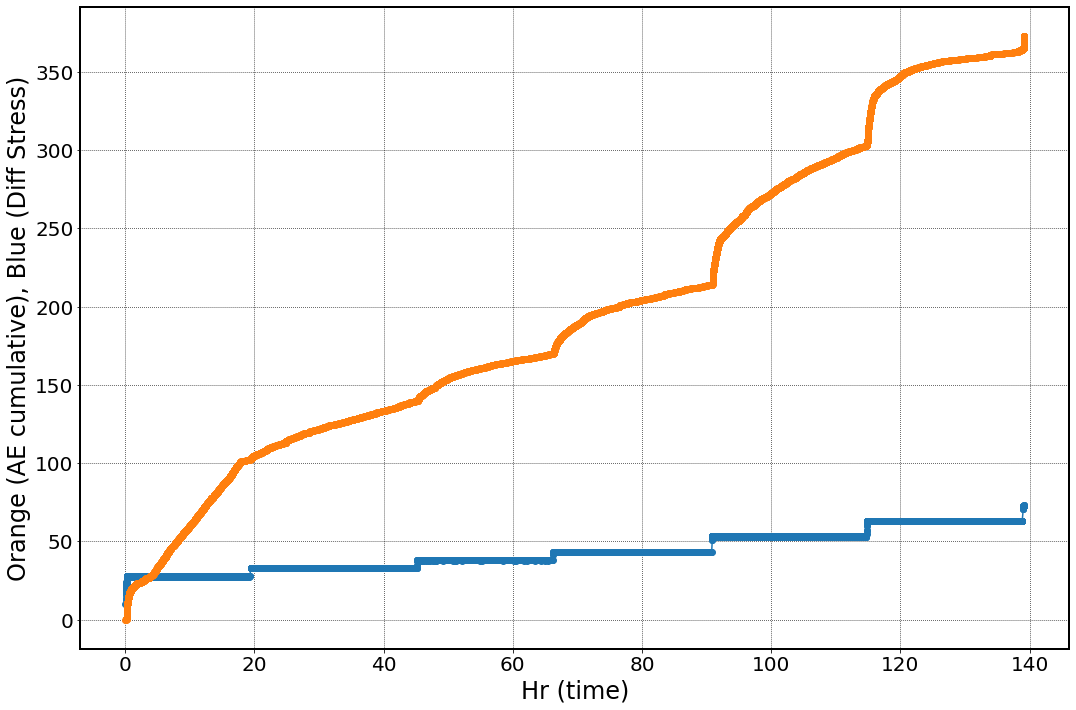

In [12]:
plt.plot(data.time_hr,data.Sig_diff_MPa,'o-')
plt.plot(data.time_hr,np.cumsum(data['count'])/30,'o-')
plt.xlabel('Hr (time)')
plt.ylabel('Orange (AE cumulative), Blue (Diff Stress)')

## Check Synchronization

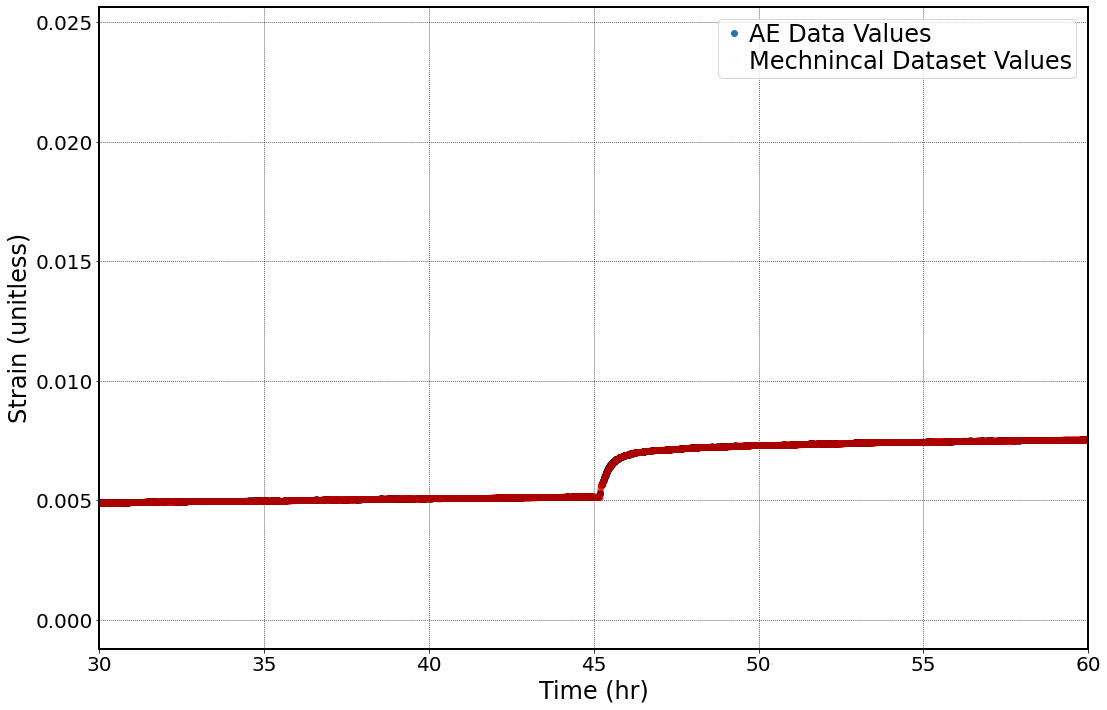

In [13]:
plt.plot(data.time_hr,data.Strain_ax,'o',label='AE Data Values')
plt.plot(data_def.time_hr,data_def.Strain_ax,'ro',alpha=0.01,label='Mechnincal Dataset Values') 
plt.xlim([30,60])
plt.xlabel('Time (hr)')
plt.ylabel('Strain (unitless)')
plt.legend()
#plt.ylim([0.,0.01])

Text(0.5, 0, 'Time (Date)')

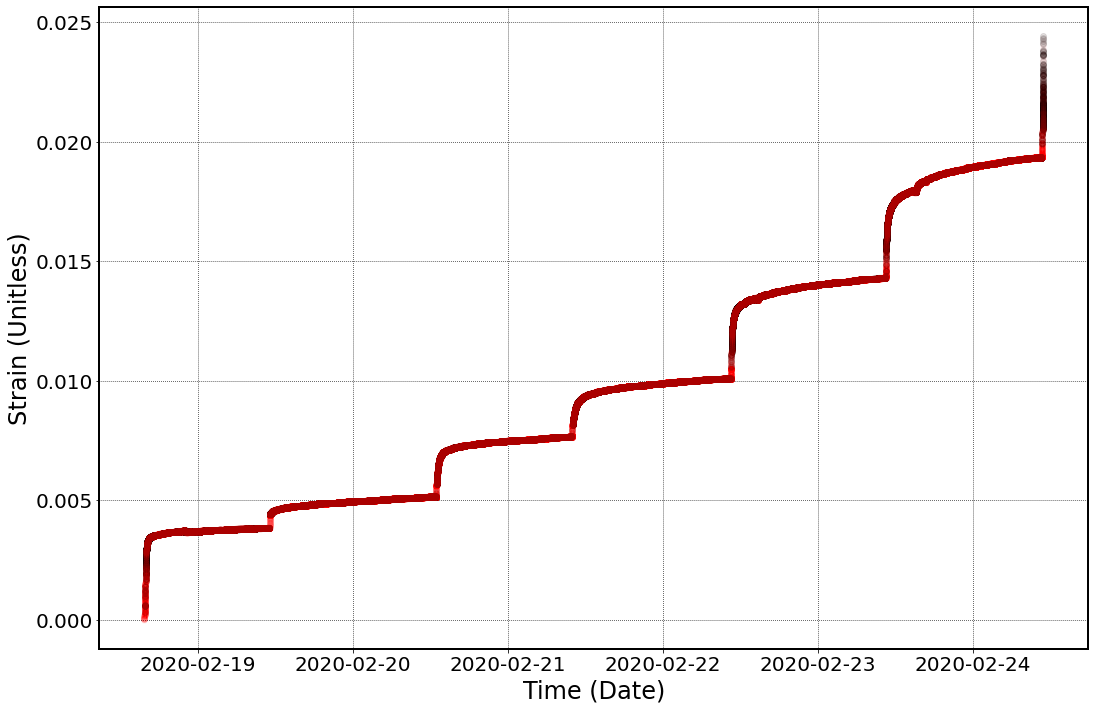

In [14]:
plt.plot(new_data.index,new_data['Strain_ax'],'ko',alpha=.1)
plt.plot(data_def.index,data_def['Strain_ax'],'ro',alpha=0.01)
plt.ylabel('Strain (Unitless)')
plt.xlabel('Time (Date)')
#plt.xlim([np.datetime64('2020-02-19'),np.datetime64('2020-02-20')])
#plt.ylim([0,0.01])
#plt.tight_layout()

### Final Cleaned, Aligned Datasets 

In [15]:
### AE dataset & deformation data with time as the index
# new_data -- AE Data
# new_data_def -- Deformation Data (resampled)

#### Time region cutoff to ensure that both the datasets are comparable

In [16]:
start_date = np.max([new_data_def.index.values[0],new_data.index.values[0]])
end_date = np.min([new_data_def.index.values[-1],new_data.index.values[-1]])
print(f'{start_date}, {end_date}')

2020-02-18T15:44:42.000000000, 2020-02-24T10:52:01.000000000


## Analysis Parts :

a) Make a catalog for the AE data with strain rate etc (extended mechanical catalog)

b) Data plotting with different time aggregations & saving time series for analysis

### Make a time aggregated dataset (mechanical data) to merge with the event catalog

In [17]:
time_window = 60  ## Aggregation Time Window in seconds

In [18]:
time_agg = str(int(time_window/60)) + 'min'
new_data_def_Sampl = hbasic.generate_data(new_data,new_data_def,time_window,start_date,end_date)
new_AE_data = pd.merge_asof(new_data, new_data_def_Sampl, left_index = True, right_index = True,
                            direction='forward',tolerance=pd.Timedelta(seconds=time_window),
             suffixes =['','_1min'])
## Note that when we aggregate, the time label is assigned to the end of the time window (right). So, for an event,
#  the relevant data is in the next timestamp (or not relevant - so we have a tolerance) ..

In [19]:
new_AE_data.columns

Index(['index', 'timestamp', 'evID', 'Disp_mm', 'Sig_diff_MPa', 'Strain_ax',
       'Temp', 'time_hr', 'count', 'Disp_mm_1min', 'Sig_diff_MPa_1min',
       'Strain_ax_1min', 't_def', 'Temp_1min', 'time_hr_1min',
       'Time_Since_Step_1', 'Time_Since_Step_2', 'Time_Since_Step_3',
       'Time_Since_Step_4', 'Time_Since_Step_5', 'AE_rate_count',
       'strain_rate', 'stress_rate', 'AE_rate_count_rate', 'Sig_AE_rate',
       'strain_rate_AE_rate', 'strain_AE_rate', 'Sig_strain',
       'Sig_strain_rate', 'Strain_strain_rate'],
      dtype='object')

In [20]:
new_AE_data

index            timestamp                       evID  \
date                                                                         
2020-02-18 15:44:42      0  1582040682000000000   2020.049.154442.56682943   
2020-02-18 15:46:38      1  1582040798000000000   2020.049.154638.56798128   
2020-02-18 15:46:38      2  1582040798000000000   2020.049.154638.56798754   
2020-02-18 15:46:39      3  1582040799000000000   2020.049.154639.56799023   
2020-02-18 15:46:40      4  1582040800000000000   2020.049.154640.56800616   
...                    ...                  ...                        ...   
2020-02-24 10:51:57  11183  1582541517000000000  2020.055.105157.557517483   
2020-02-24 10:51:58  11184  1582541518000000000  2020.055.105158.557518179   
2020-02-24 10:51:59  11185  1582541519000000000  2020.055.105159.557519657   
2020-02-24 10:52:00  11186  1582541520000000000  2020.055.105200.557520179   
2020-02-24 10:52:01  11187  1582541521000000000  2020.055.105201.557521925   

                     Disp_mm  Sig_diff_MPa  Strain_ax     Temp     time_hr  \
date                                                                         
2020-02-18 15:44:42  4.10771       10.2518   0.000313  78.5341    0.033889   
2020-02-18 15:46:38  4.13035       12.9187   0.000590  78.5705    0.066111   
2020-02-18 15:46:38  4.13035       12.9187   0.000590  78.5705    0.066111   
2020-02-18 15:46:39  4.13177       12.9187   0.000608  78.5705    0.066389   
2020-02-18 15:46:40  4.13177       13.2997   0.000608  78.5341    0.066667   
...                      ...           ...        ...      ...         ...   
2020-02-24 10:51:57  6.05047       72.7331   0.024150  78.7889  139.154722   
2020-02-24 10:51:58  6.05613       72.7331   0.024220  78.8617  139.155000   
2020-02-24 10:51:59  6.06320       72.7331   0.024306  78.8617  139.155278   
2020-02-24 10:52:00  6.06603       72.7331   0.024341  78.8253  139.155556   
2020-02-24 10:52:01  6.07311       72.3521   0.024428  78.8981  139.155833   

                     count  Disp_mm_1min  ...  AE_rate_count  strain_rate  \
date                                      ...                               
2020-02-18 15:44:42    1.0      4.105425  ...            1.0     0.000000   
2020-02-18 15:46:38    1.0      4.127995  ...            4.0     0.000137   
2020-02-18 15:46:38    1.0      4.127995  ...            4.0     0.000137   
2020-02-18 15:46:39    1.0      4.127995  ...            4.0     0.000137   
2020-02-18 15:46:40    1.0      4.127995  ...            4.0     0.000137   
...                    ...           ...  ...            ...          ...   
2020-02-24 10:51:57    1.0      5.963540  ...           51.0     0.001200   
2020-02-24 10:51:58    1.0      5.963540  ...           51.0     0.001200   
2020-02-24 10:51:59    1.0      5.963540  ...           51.0     0.001200   
2020-02-24 10:52:00    1.0      5.963540  ...           51.0     0.001200   
2020-02-24 10:52:01    1.0           NaN  ...            NaN          NaN   

                     stress_rate  AE_rate_count_rate  Sig_AE_rate  \
date                                                                
2020-02-18 15:44:42     0.000000                 0.0     0.000000   
2020-02-18 15:46:38     1.142932                 4.0     0.002744   
2020-02-18 15:46:38     1.142932                 4.0     0.002744   
2020-02-18 15:46:39     1.142932                 4.0     0.002744   
2020-02-18 15:46:40     1.142932                 4.0     0.002744   
...                          ...                 ...          ...   
2020-02-24 10:51:57    -0.050800                -4.0     0.909789   
2020-02-24 10:51:58    -0.050800                -4.0     0.909789   
2020-02-24 10:51:59    -0.050800                -4.0     0.909789   
2020-02-24 10:52:00    -0.050800                -4.0     0.909789   
2020-02-24 10:52:01          NaN                 NaN          NaN   

                     strain_rate_AE_rate  strain_AE_rate  Sig_strain  \
date               

In [21]:
time_window = 60
time_agg = str(int(time_window/60)) + 'min'
new_data_def_Sampl = hbasic.generate_data(new_data,new_data_def,time_window,start_date,end_date)
print(new_data_def_Sampl.columns)
   

Index(['Disp_mm', 'Sig_diff_MPa', 'Strain_ax', 't_def', 'Temp', 'time_hr',
       'Time_Since_Step_1', 'Time_Since_Step_2', 'Time_Since_Step_3',
       'Time_Since_Step_4', 'Time_Since_Step_5', 'AE_rate_count',
       'strain_rate', 'stress_rate', 'AE_rate_count_rate', 'Sig_AE_rate',
       'strain_rate_AE_rate', 'strain_AE_rate', 'Sig_strain',
       'Sig_strain_rate', 'Strain_strain_rate'],
      dtype='object')


In [ ]:
%matplotlib qt
plt.plot(new_AE_data['time_hr'],new_AE_data['Sig_diff_MPa'],'o')
plt.plot(new_data_def_Sampl['time_hr'],new_data_def_Sampl['Sig_diff_MPa'],'k-',alpha=0.2)
plt.plot(new_AE_data['time_hr'],new_AE_data['Strain_ax']*3000,'ro')
plt.plot(new_data_def_Sampl['time_hr'],new_data_def_Sampl['Strain_ax']*3000,'r-',alpha=0.2)
plt.plot(new_data_def_Sampl['time_hr'],new_data_def_Sampl['AE_rate_count']*3,'b-')

In [21]:
new_AE_data.to_csv(path_AE_data.split('.csv')[0]+'_AppendedMechanical_'+time_agg+'.csv')

In [22]:
del new_AE_data

## Plotting/Analysis of the data with AE rate etc 

In [23]:
try  :
    os.mkdir(path_to_save_out_time_series+name_exp)
except :
    print(f' {path_to_save_out_time_series+name_exp} Exists')
    
try  :
    os.mkdir(path_to_save_out_time_series+name_exp+'/'+time_agg)
except :
    print(f"{path_to_save_out_time_series+name_exp+'/'+time_agg} Exists")

path_save_file = path_to_save_out_time_series+name_exp+'/'+time_agg

 /home/tmittal/Causality/Basalt_Data/dataforcausalitytests_Wet_Basalt Exists
/home/tmittal/Causality/Basalt_Data/dataforcausalitytests_Wet_Basalt/1min Exists


Index(['Disp_mm', 'Sig_diff_MPa', 'Strain_ax', 't_def', 'Temp', 'time_hr',
       'Time_Since_Step_1', 'Time_Since_Step_2', 'Time_Since_Step_3',
       'Time_Since_Step_4', 'Time_Since_Step_5', 'AE_rate_count',
       'strain_rate', 'stress_rate', 'AE_rate_count_rate', 'Sig_AE_rate',
       'strain_rate_AE_rate', 'strain_AE_rate', 'Sig_strain',
       'Sig_strain_rate', 'Strain_strain_rate'],
      dtype='object')
Output_Plots Exists
Output_Plots/Wet_Basalt Exists
Index value for the stress steps:  [   1   14  394 1163 2711 3975 5452 6084 6890]
Time(hr) for the stress steps:  [4.68055556e-02 6.59680556e+00 1.94134722e+01 4.52134722e+01
 6.62801389e+01 9.08968056e+01 1.01430139e+02 1.14863472e+02]


10

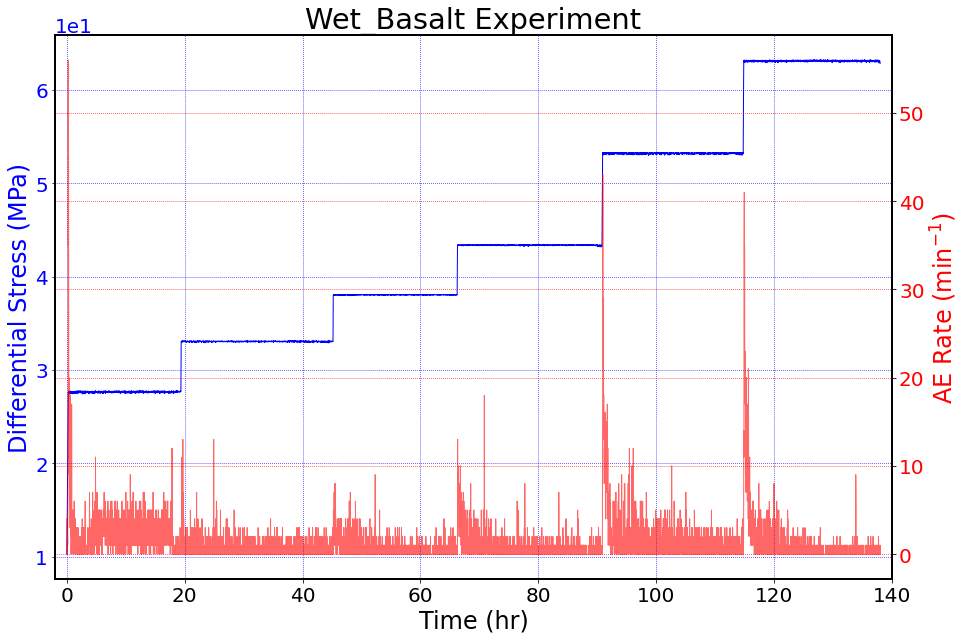

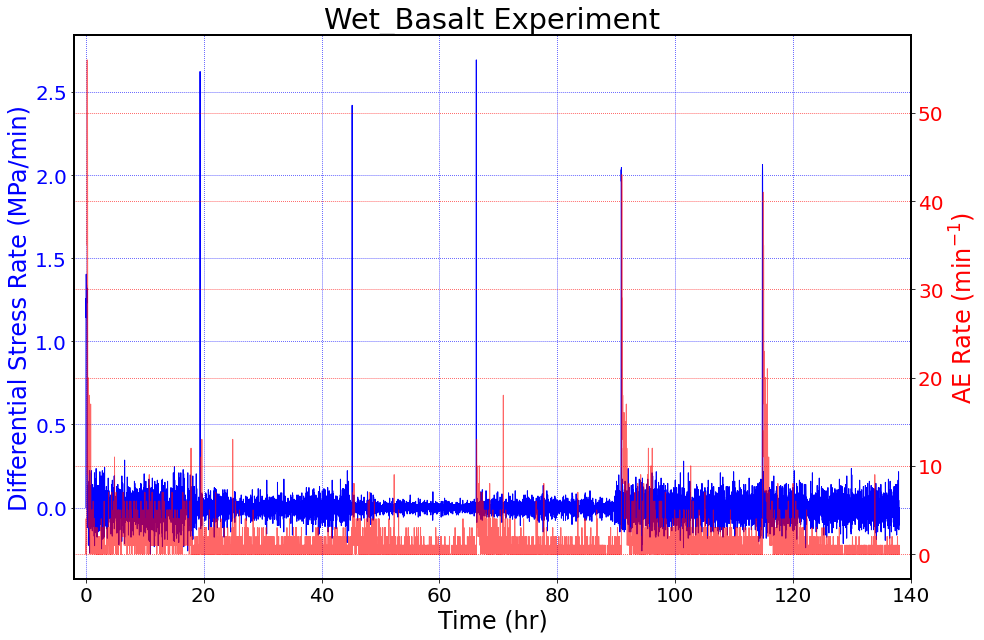

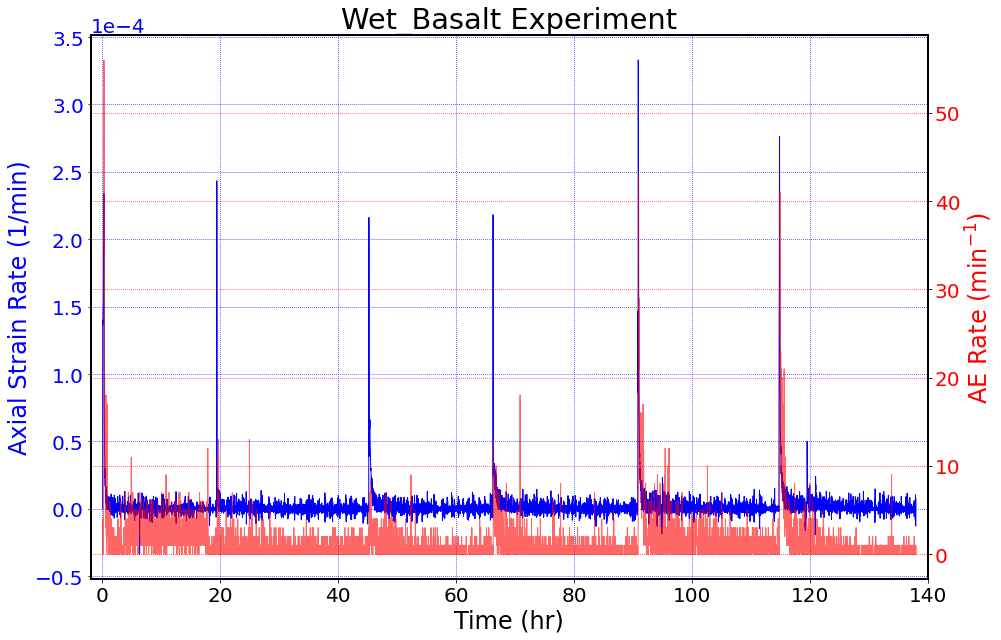

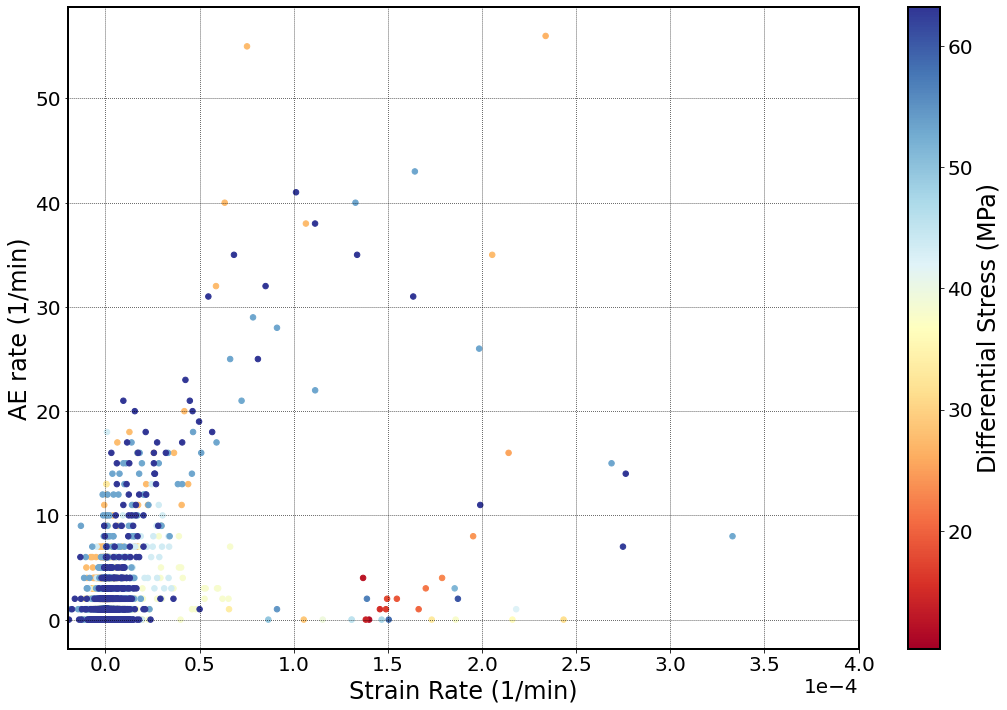

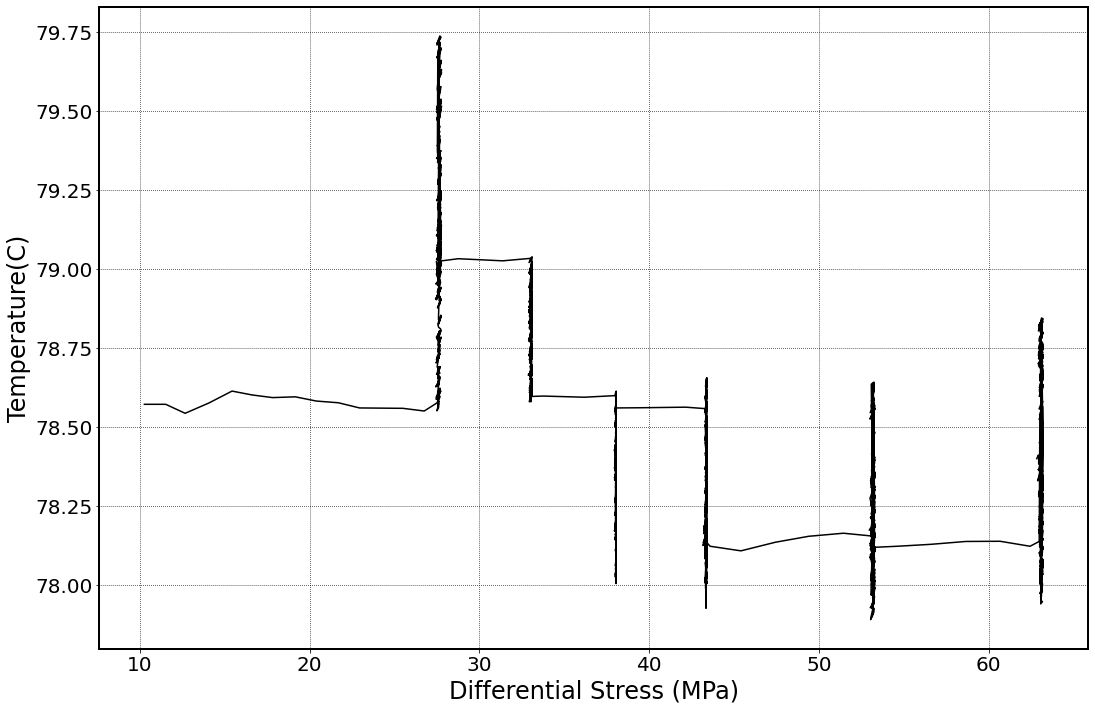

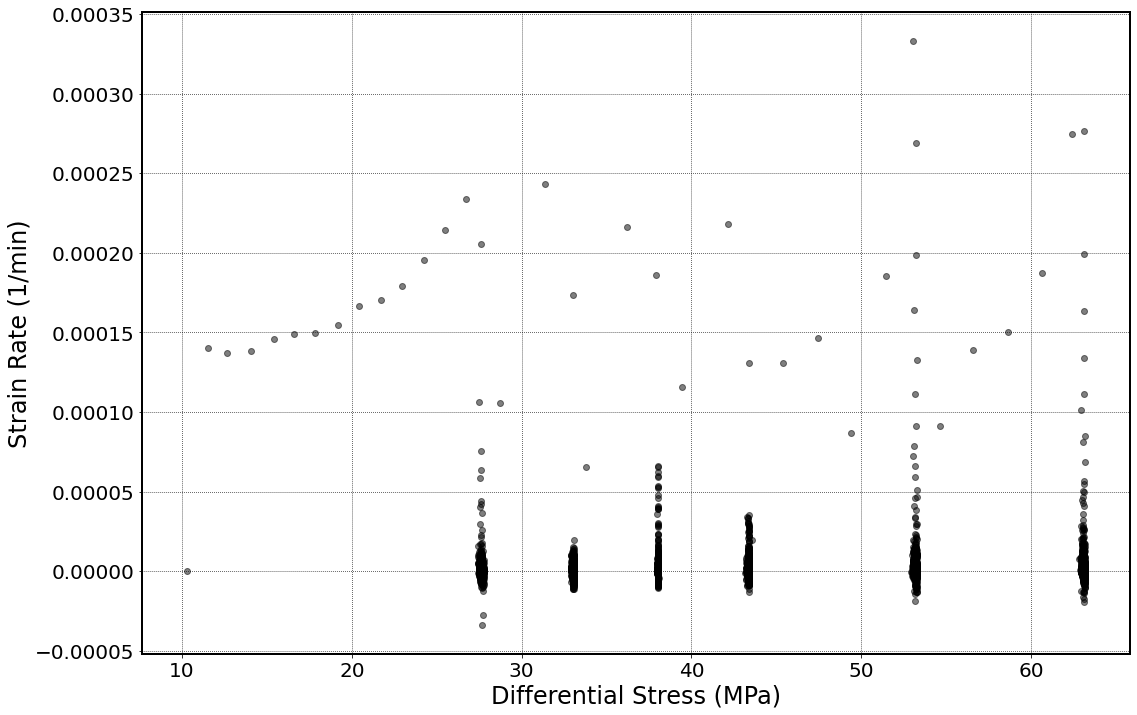

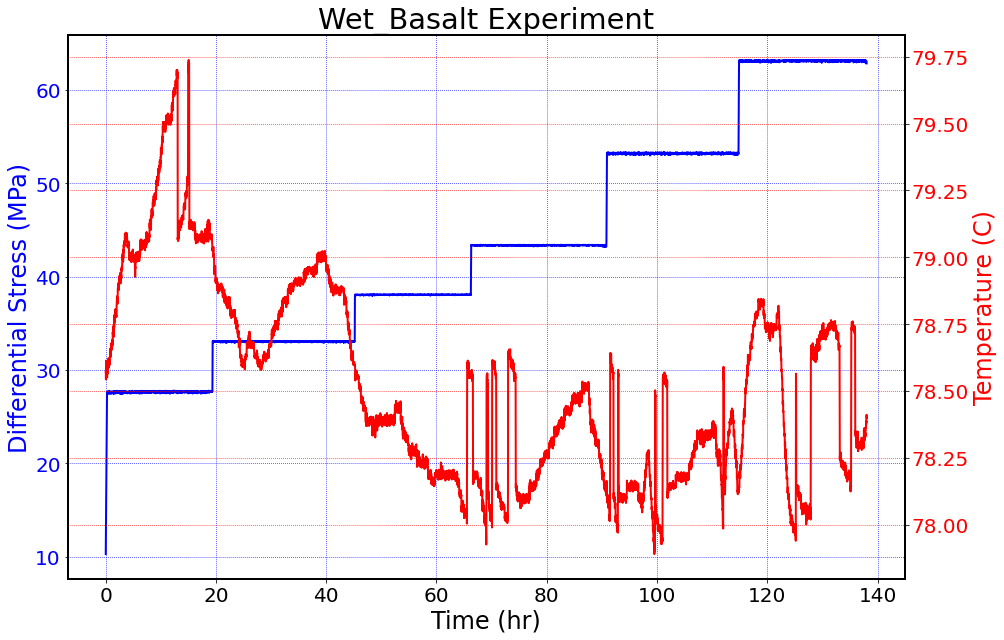

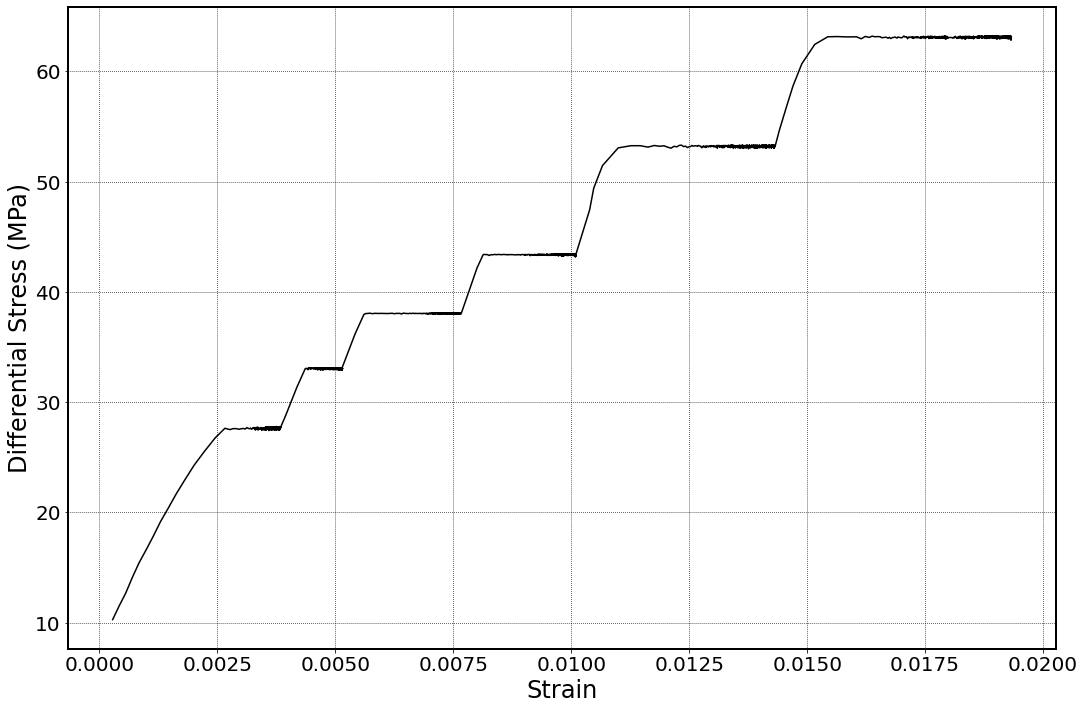

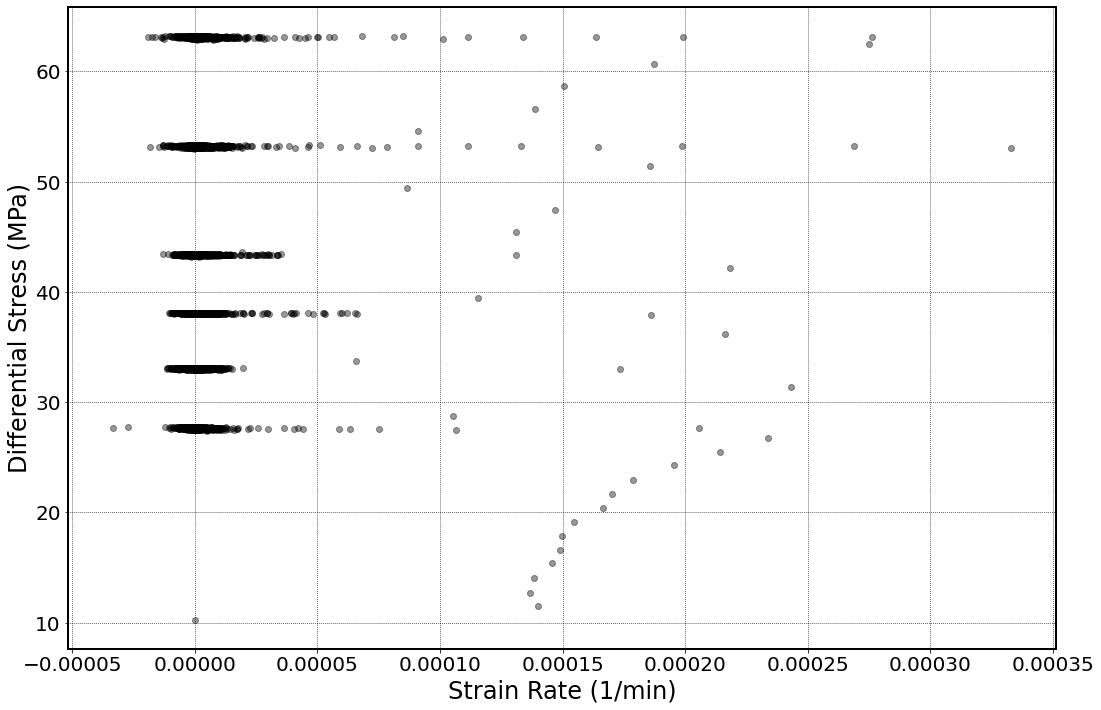

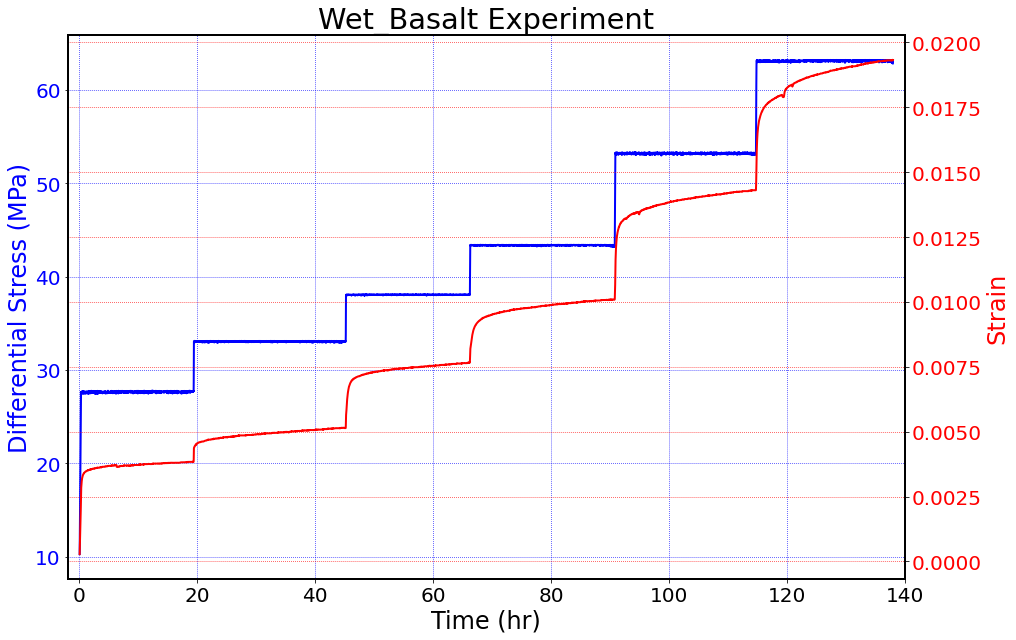

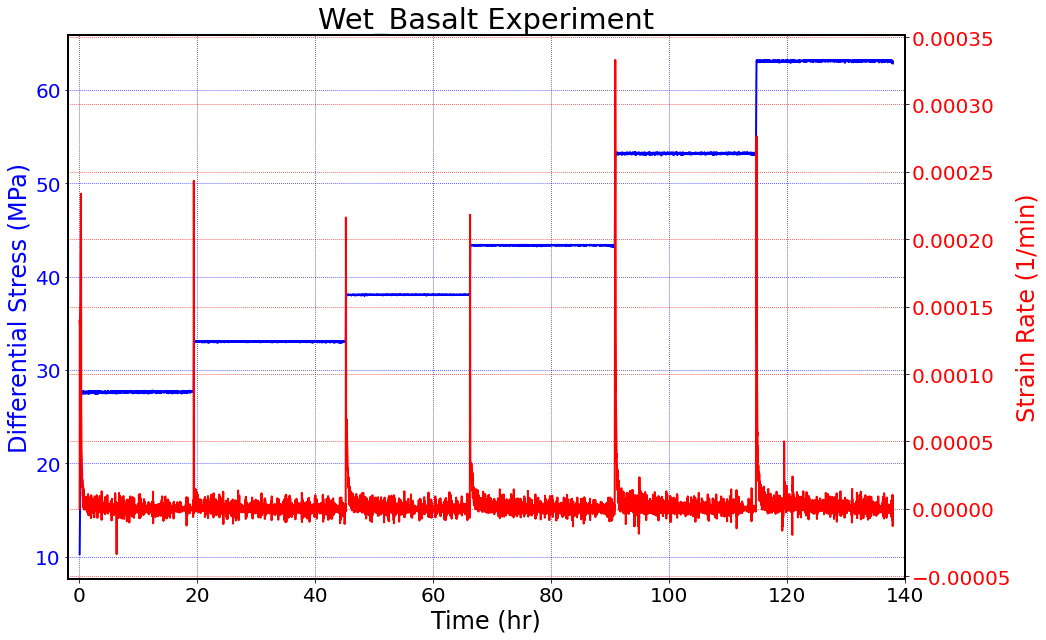

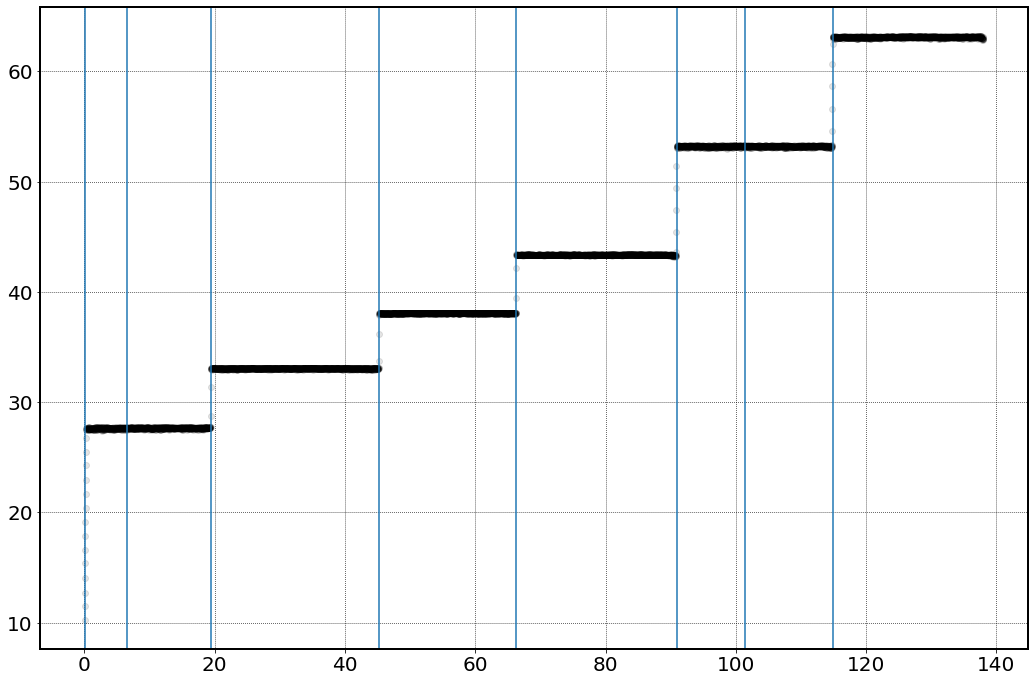

In [24]:
time_window = 60
time_agg = str(int(time_window/60)) + 'min'
new_data_def_Sampl = hbasic.generate_data(new_data,new_data_def,time_window,start_date,end_date)
print(new_data_def_Sampl.columns)
   
new_data_def_Sampl = new_data_def_Sampl.loc[new_data_def_Sampl['time_hr']<=138.,:]
hbasic.make_plots_exp_Dataset(new_data_def_Sampl,name_exp,time_window)

### Finding the steps in the stress based on stress rate
grad_stress = new_data_def_Sampl['stress_rate']
pot_steps = np.where(grad_stress>0.25)[0]
indx = np.hstack([0,np.where(np.diff(new_data_def_Sampl.time_hr[pot_steps])>5)[0],-1])
print('Index value for the stress steps: ' ,pot_steps[indx])
indx = np.hstack([indx[0],indx[2:]])
time_steps = new_data_def_Sampl.time_hr[pot_steps[indx]].reset_index(drop=True)
print('Time(hr) for the stress steps: ',time_steps.values)

plt.figure()
plt.plot(new_data_def_Sampl.time_hr,new_data_def_Sampl.Sig_diff_MPa,'-ko',linewidth=0.1,alpha=0.1)
for k in pot_steps[indx]:
    plt.axvline(x=new_data_def_Sampl.time_hr[k])

    
# import gc
# gc.collect()

scaled_data1 = MinMaxScaler().fit_transform(new_data_def_Sampl)
scaled_data2 = RobustScaler().fit_transform(new_data_def_Sampl)

hbasic.make_file(new_data_def_Sampl,scaled_data1,path_save_file+'MinMax')
hbasic.make_file(new_data_def_Sampl,scaled_data2,path_save_file+'Robust')
del new_data_def_Sampl;

gc.collect()


Index(['Disp_mm', 'Sig_diff_MPa', 'Strain_ax', 't_def', 'Temp', 'time_hr',
       'Time_Since_Step_1', 'Time_Since_Step_2', 'Time_Since_Step_3',
       'Time_Since_Step_4', 'Time_Since_Step_5', 'AE_rate_count',
       'strain_rate', 'stress_rate', 'AE_rate_count_rate', 'Sig_AE_rate',
       'strain_rate_AE_rate', 'strain_AE_rate', 'Sig_strain',
       'Sig_strain_rate', 'Strain_strain_rate'],
      dtype='object')
Output_Plots Exists
Output_Plots/Wet_Basalt Exists
Index value for the stress steps:  [   1    7  582 1356 1988 2726 3445]
Time(hr) for the stress steps:  [7.18055556e-02 1.94384722e+01 4.52384722e+01 6.63051389e+01
 9.09051389e+01 1.14871806e+02]


54386

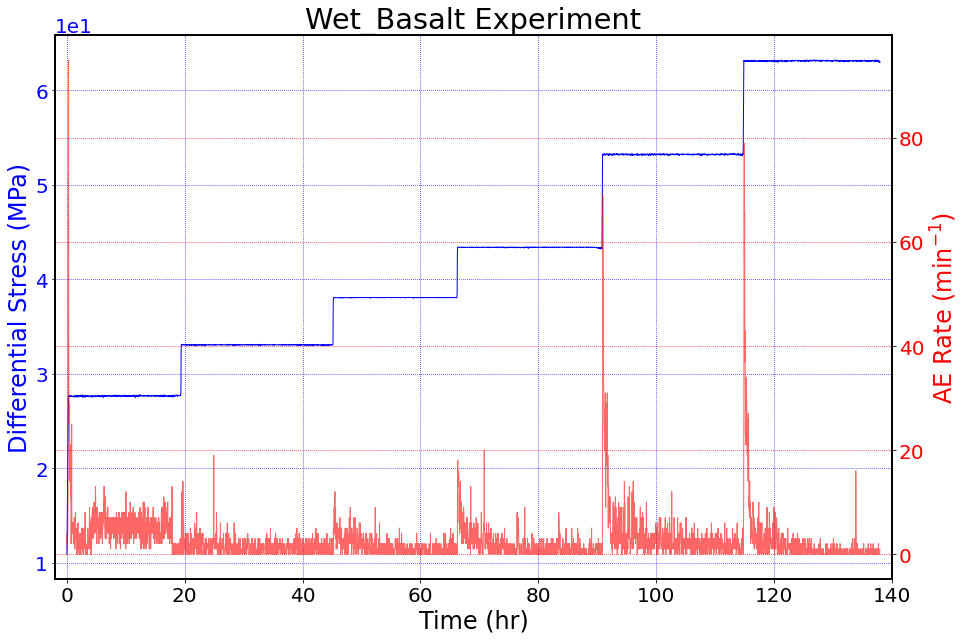

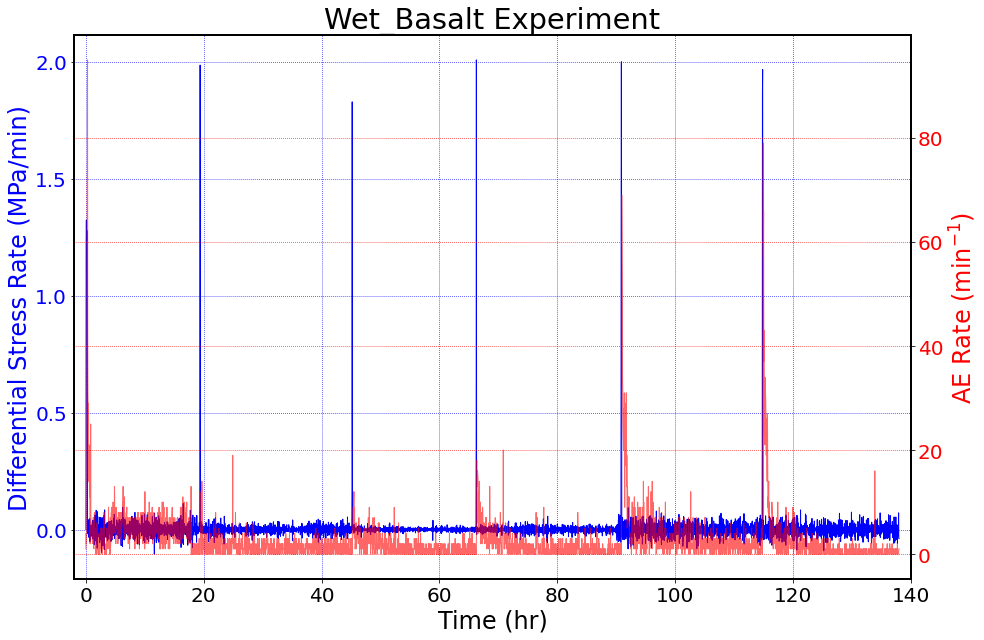

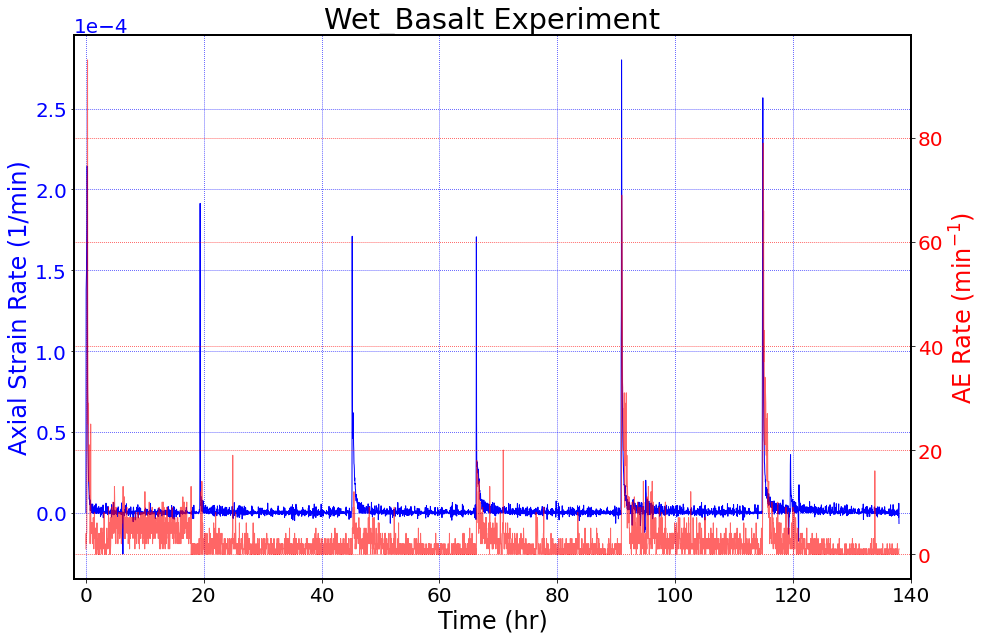

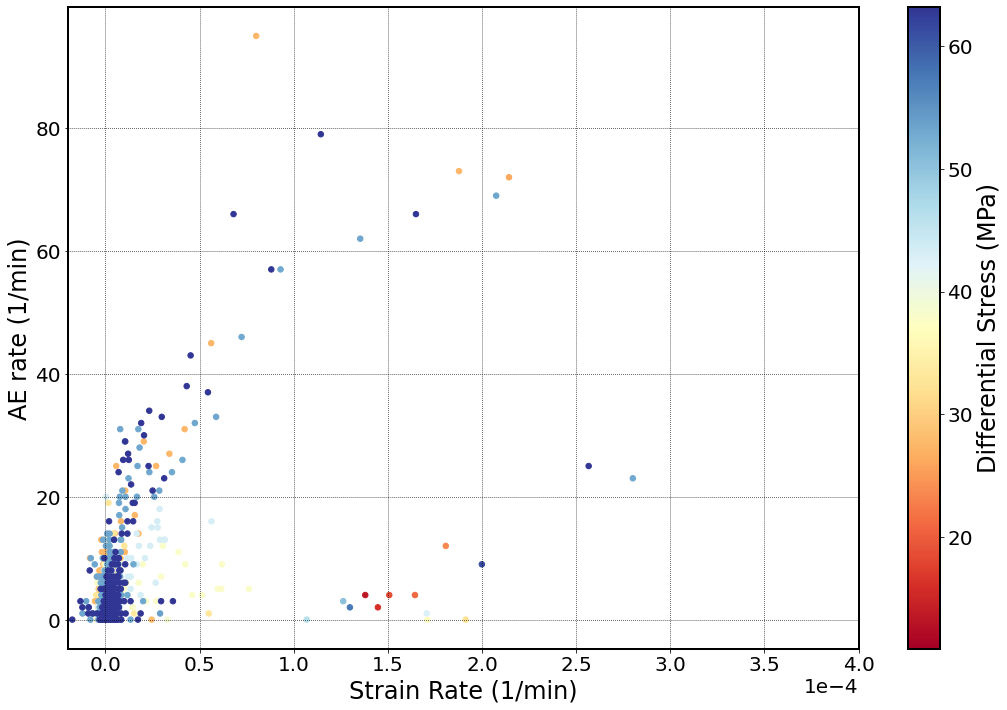

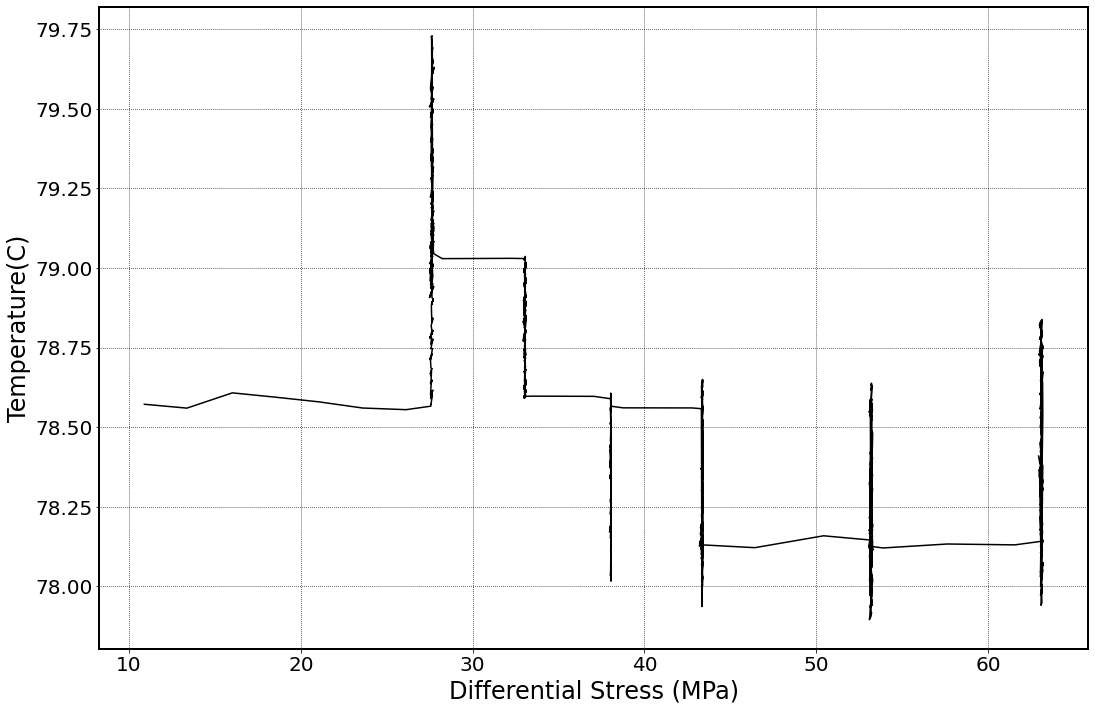

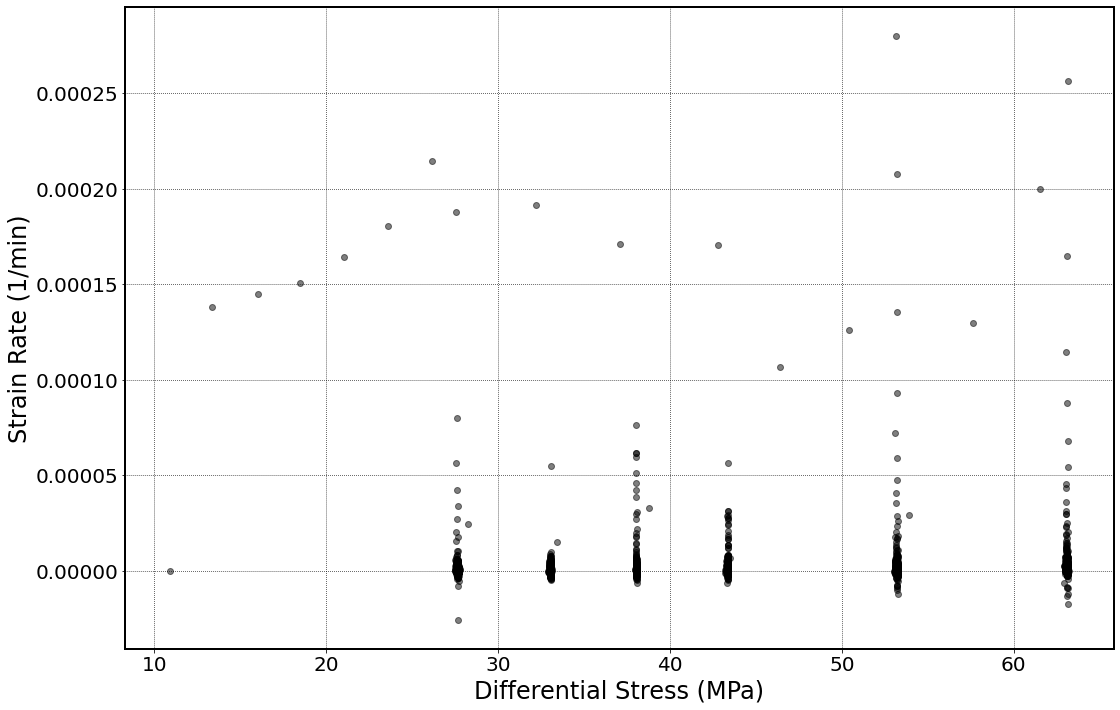

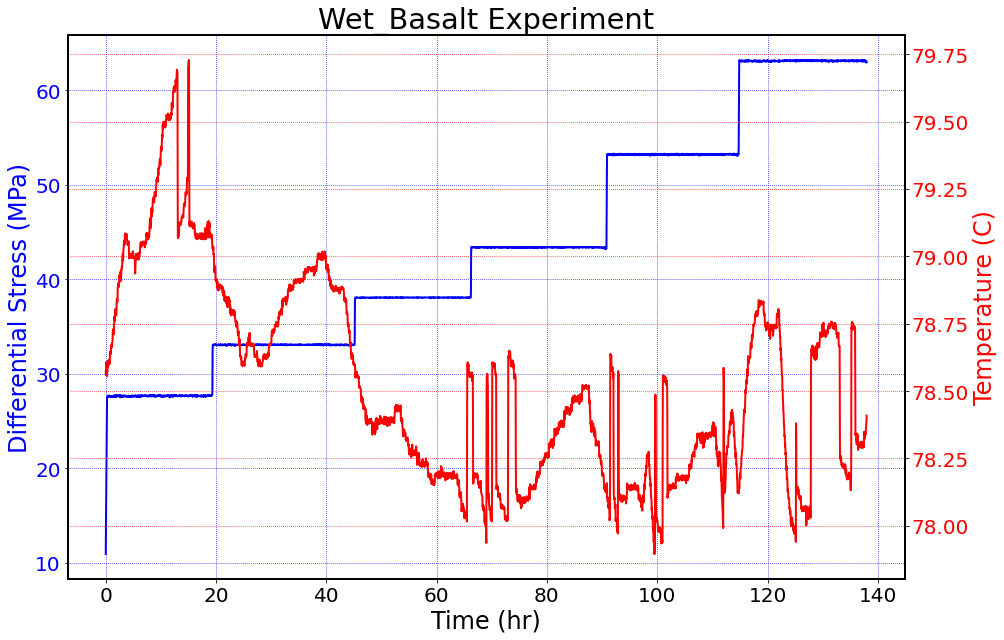

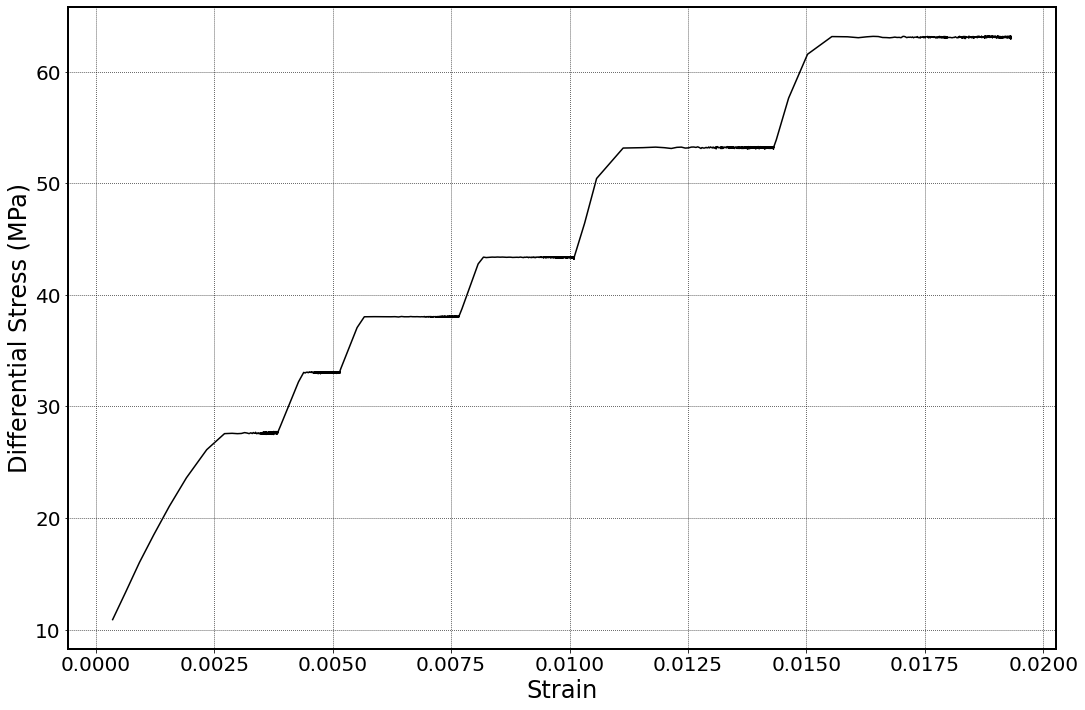

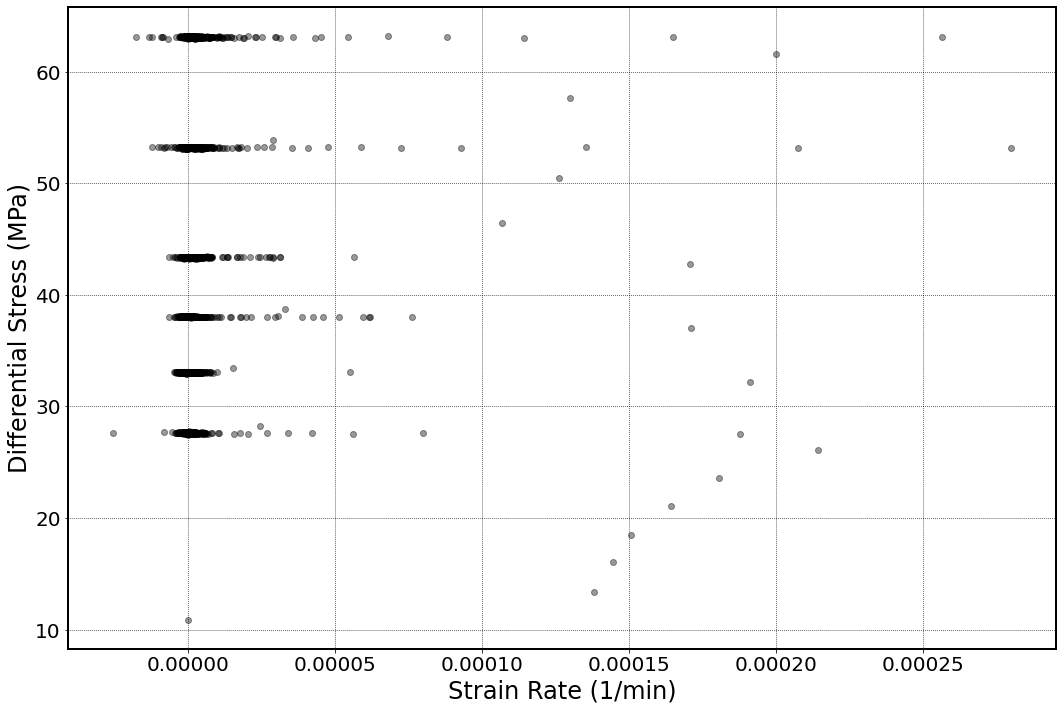

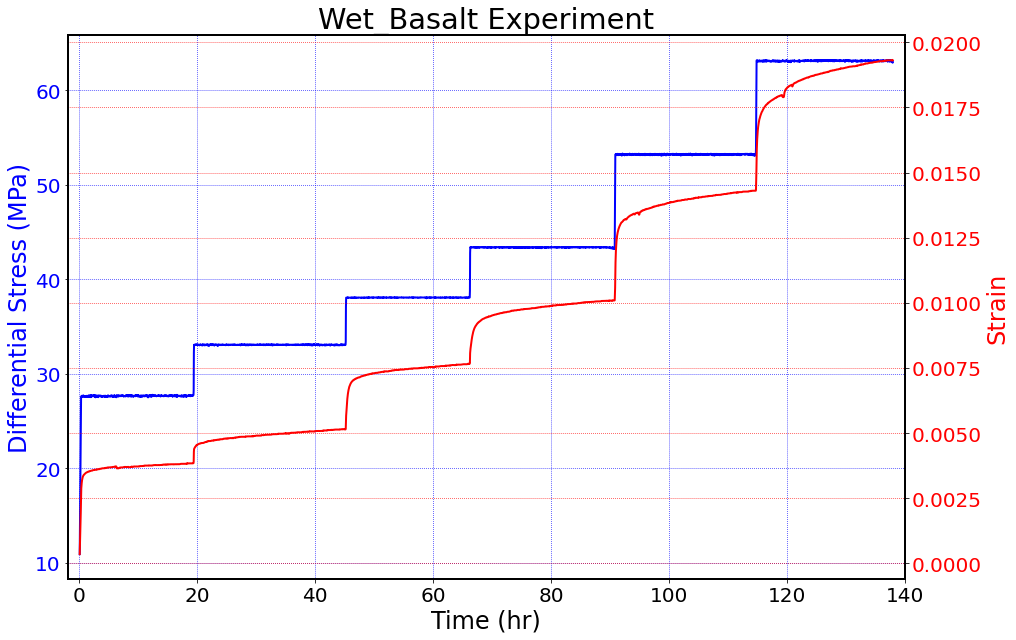

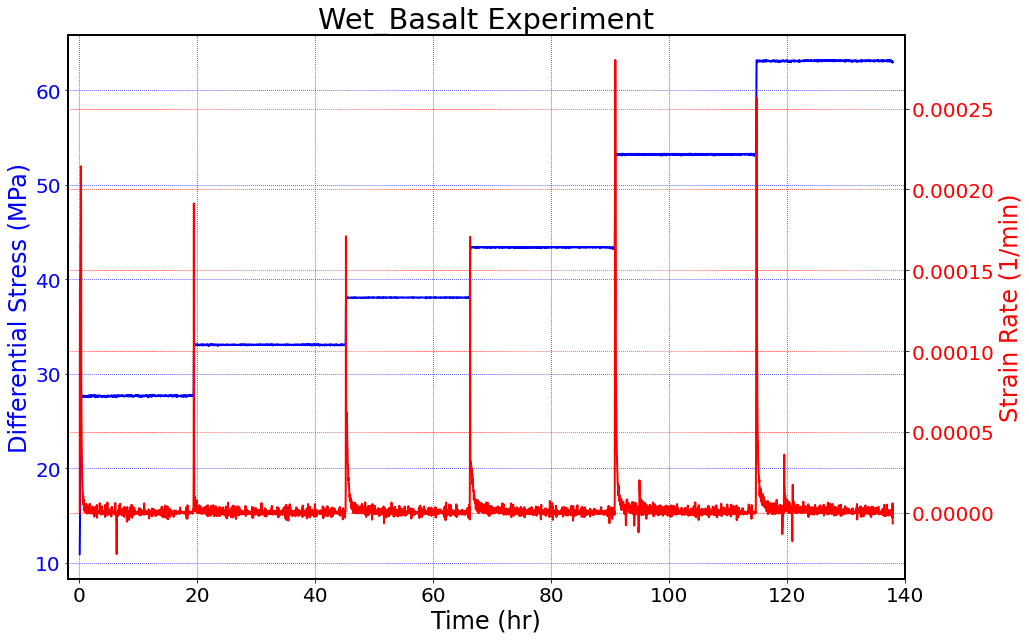

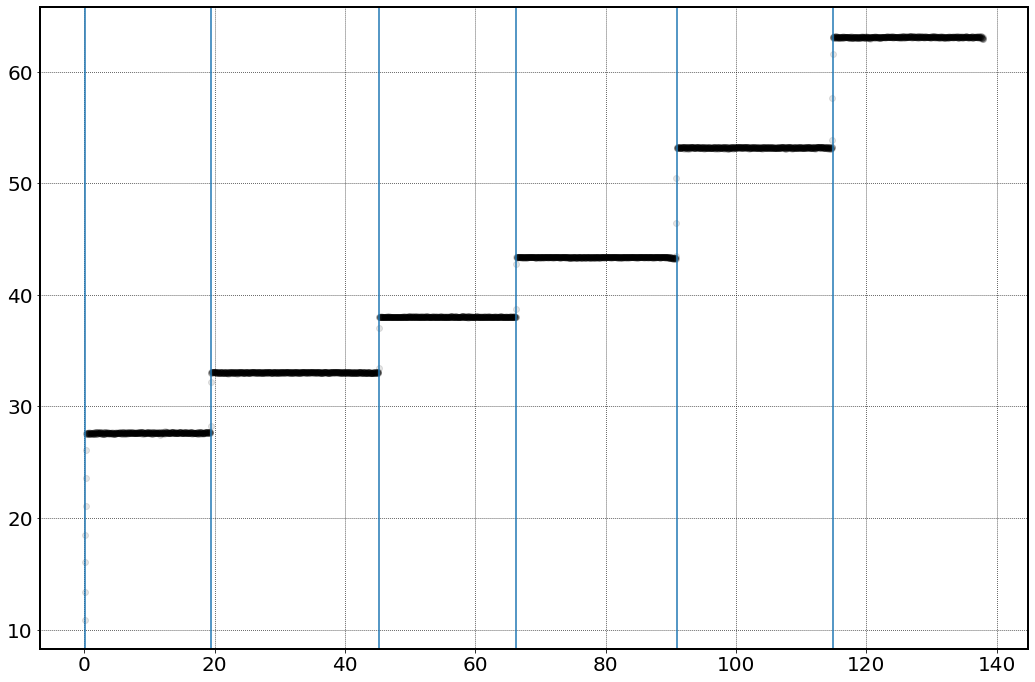

In [25]:
time_window = 120
time_agg = str(int(time_window/60)) + 'min'
new_data_def_Sampl = hbasic.generate_data(new_data,new_data_def,time_window,start_date,end_date)
print(new_data_def_Sampl.columns)
   
new_data_def_Sampl = new_data_def_Sampl.loc[new_data_def_Sampl['time_hr']<=138.,:]
hbasic.make_plots_exp_Dataset(new_data_def_Sampl,name_exp,time_window)

### Finding the steps in the stress based on stress rate
grad_stress = new_data_def_Sampl['stress_rate']
pot_steps = np.where(grad_stress>0.25)[0]
indx = np.hstack([0,np.where(np.diff(new_data_def_Sampl.time_hr[pot_steps])>5)[0],-1])
print('Index value for the stress steps: ' ,pot_steps[indx])
indx = np.hstack([indx[0],indx[2:]])
time_steps = new_data_def_Sampl.time_hr[pot_steps[indx]].reset_index(drop=True)
print('Time(hr) for the stress steps: ',time_steps.values)

plt.figure()
plt.plot(new_data_def_Sampl.time_hr,new_data_def_Sampl.Sig_diff_MPa,'-ko',linewidth=0.1,alpha=0.1)
for k in pot_steps[indx]:
    plt.axvline(x=new_data_def_Sampl.time_hr[k])

    
# import gc
# gc.collect()

scaled_data1 = MinMaxScaler().fit_transform(new_data_def_Sampl)
scaled_data2 = RobustScaler().fit_transform(new_data_def_Sampl)

hbasic.make_file(new_data_def_Sampl,scaled_data1,path_save_file+'MinMax')
hbasic.make_file(new_data_def_Sampl,scaled_data2,path_save_file+'Robust')
del new_data_def_Sampl;

gc.collect()


Index(['Disp_mm', 'Sig_diff_MPa', 'Strain_ax', 't_def', 'Temp', 'time_hr',
       'AE_rate_count', 'strain_rate', 'stress_rate', 'AE_rate_count_rate',
       'Sig_AE_rate', 'strain_rate_AE_rate', 'strain_AE_rate', 'Sig_strain',
       'Sig_strain_rate', 'Strain_strain_rate'],
      dtype='object')
Output_Plots Exists
Output_Plots/Wet_Basalt Exists
Index value for the stress steps:  [   1    5  388  904 1326 1818 2297]
Time(hr) for the stress steps:  [6.34722222e-02 1.94134722e+01 4.52134722e+01 6.63134722e+01
 9.09134722e+01 1.14863472e+02]


53932

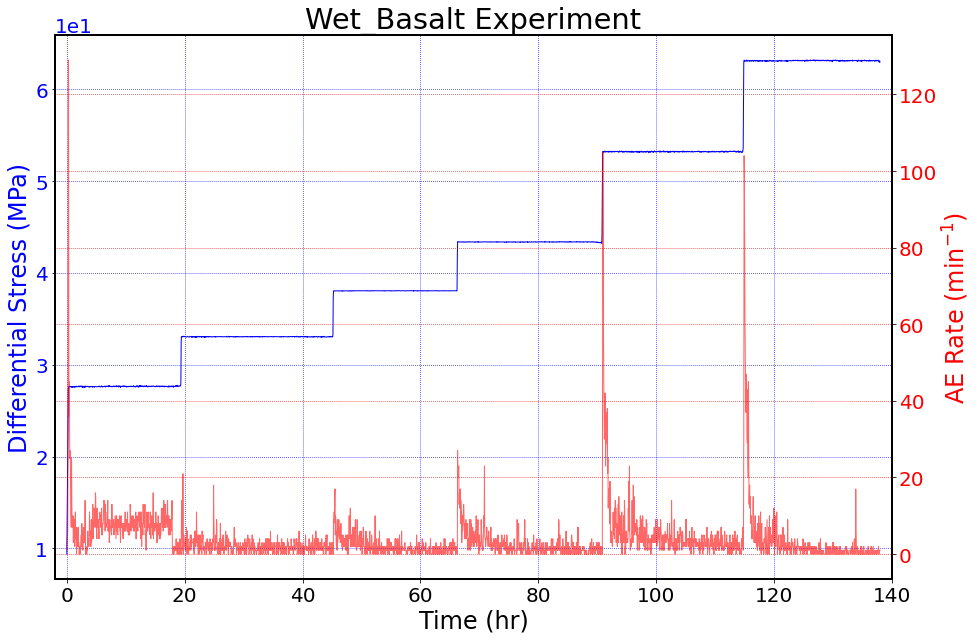

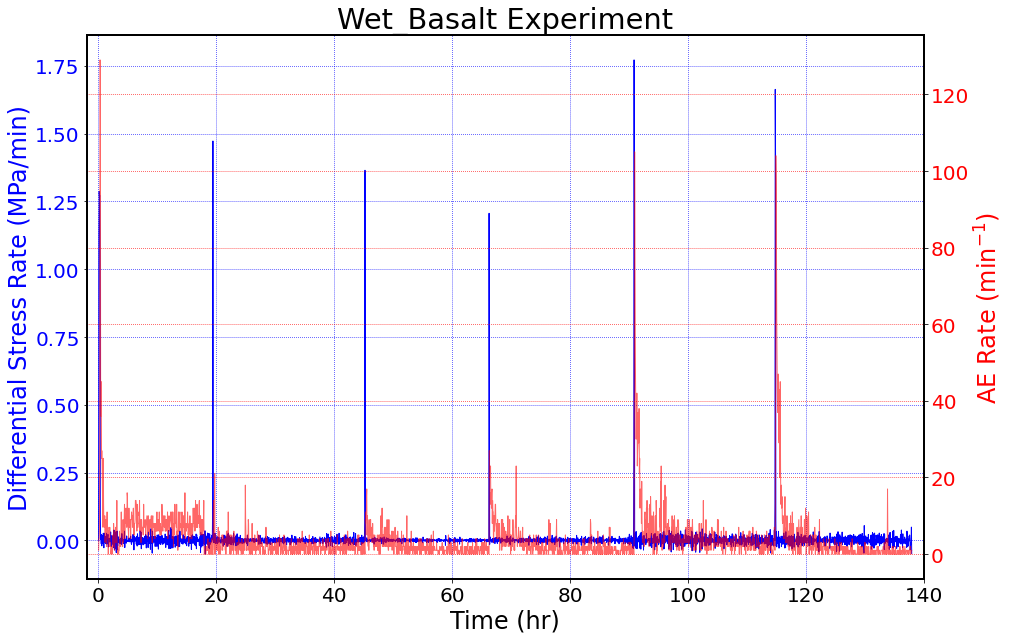

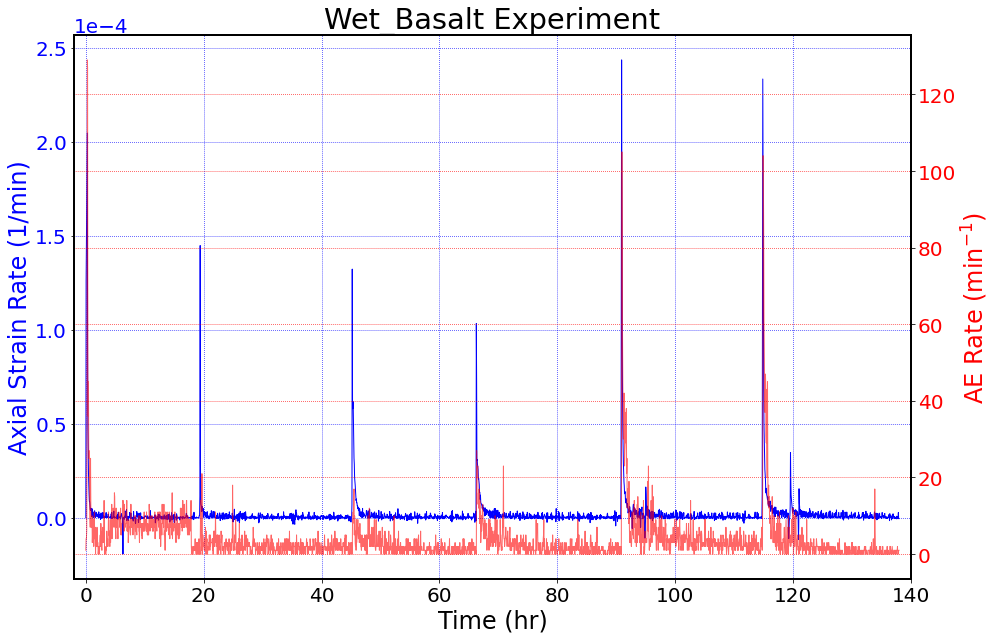

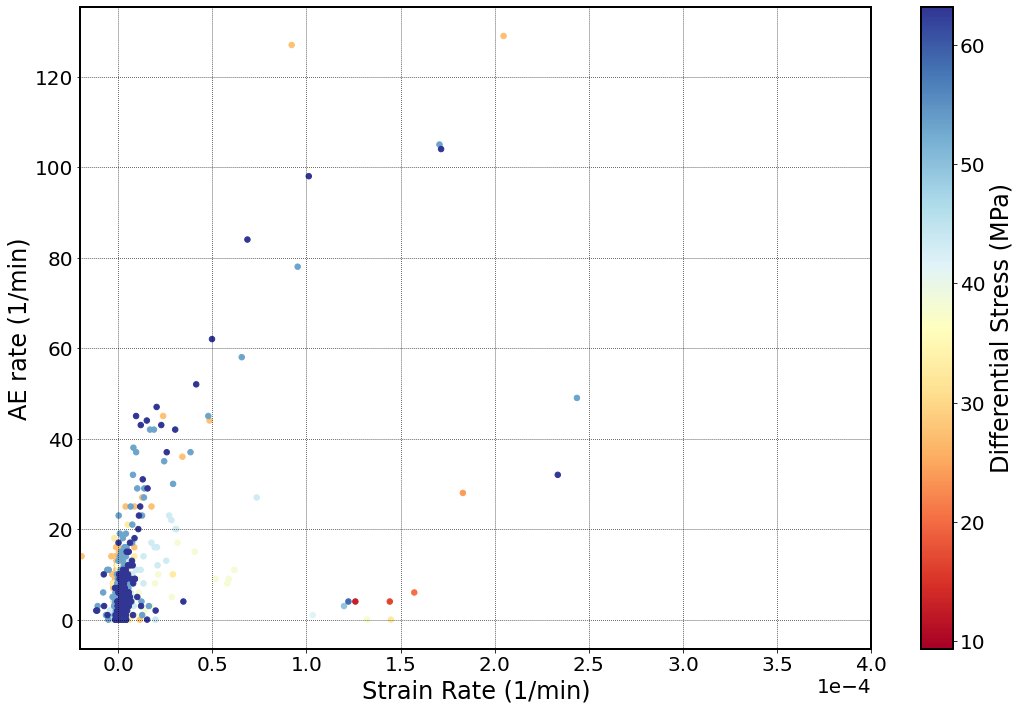

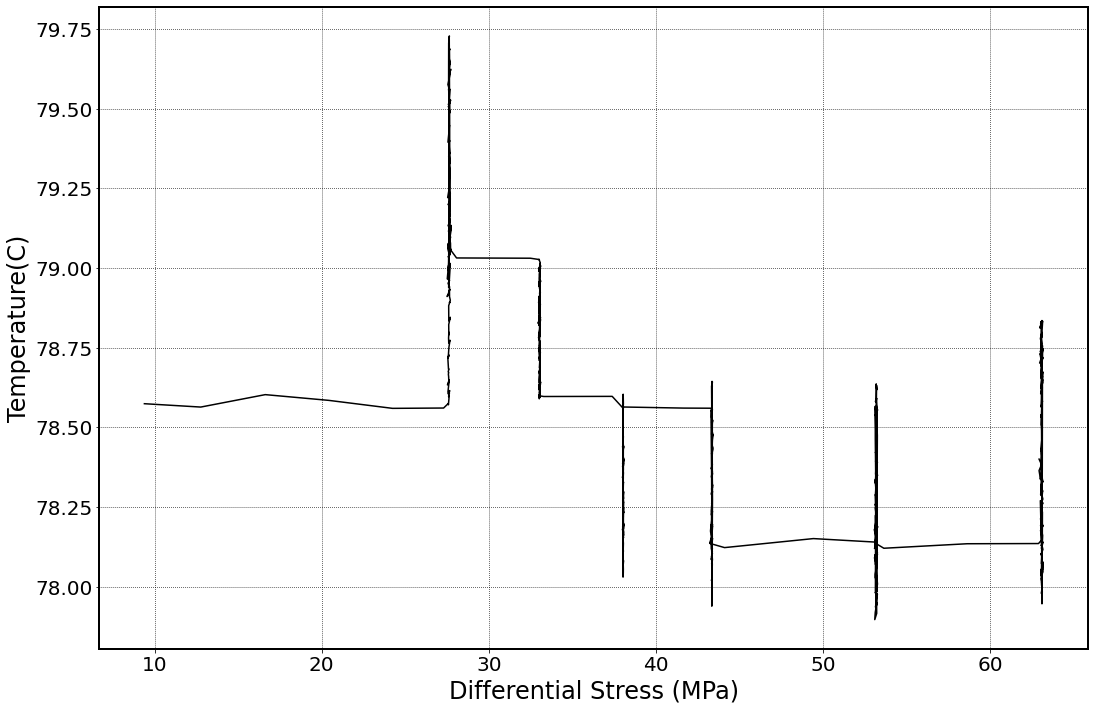

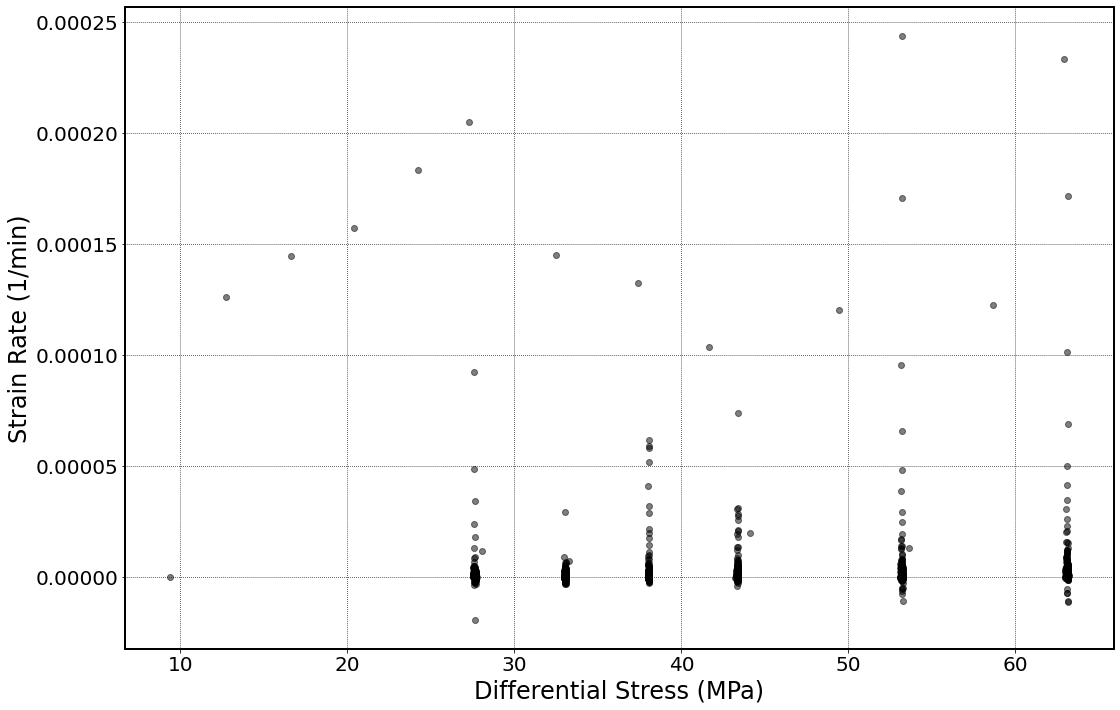

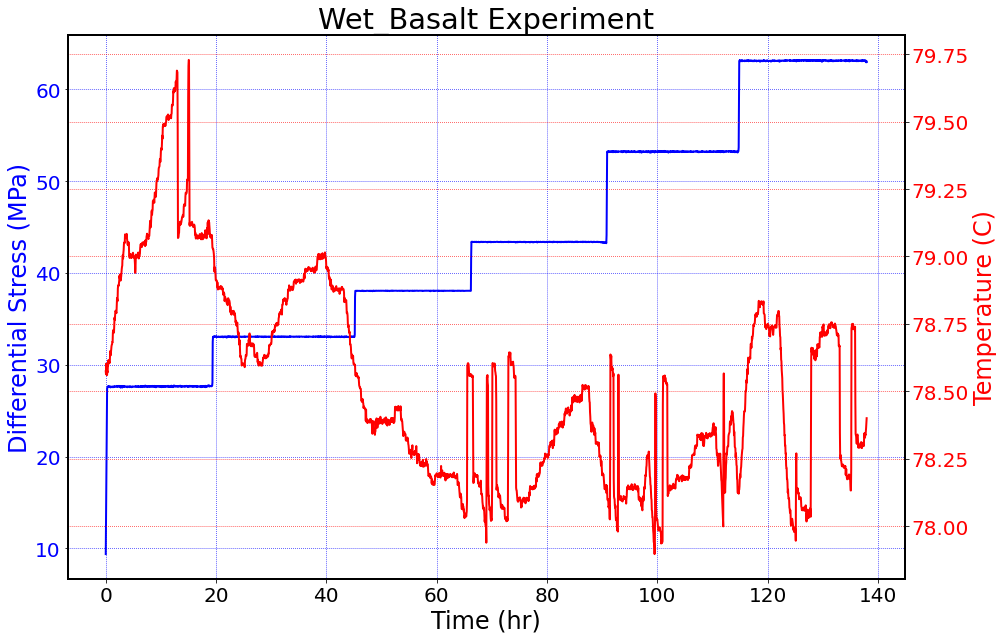

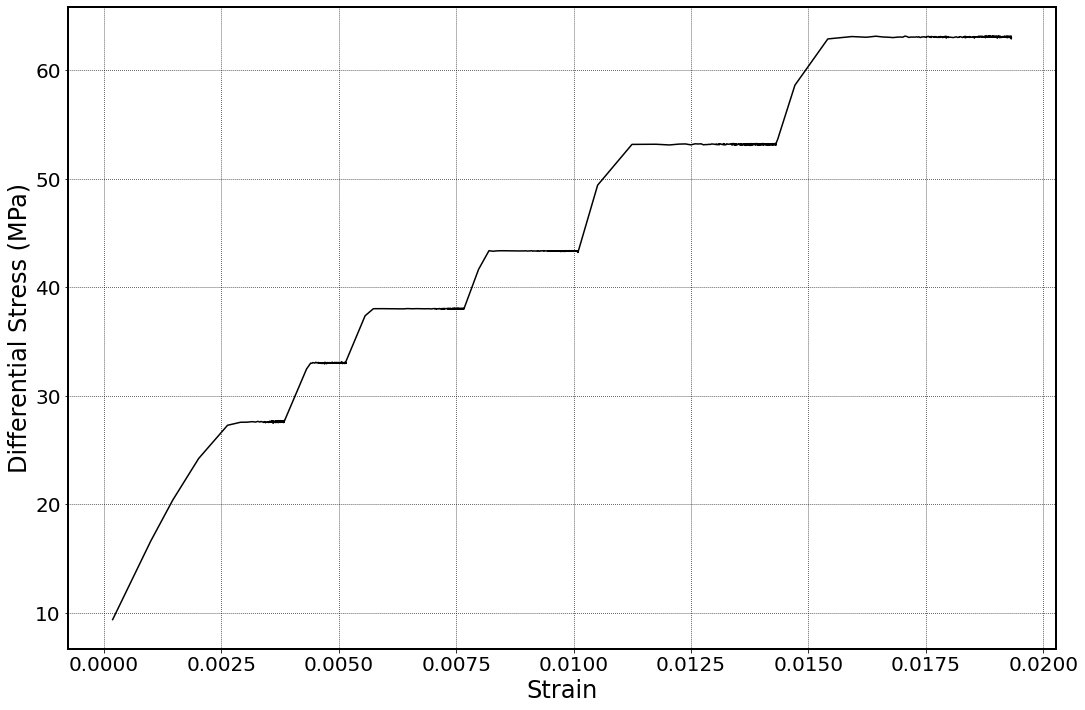

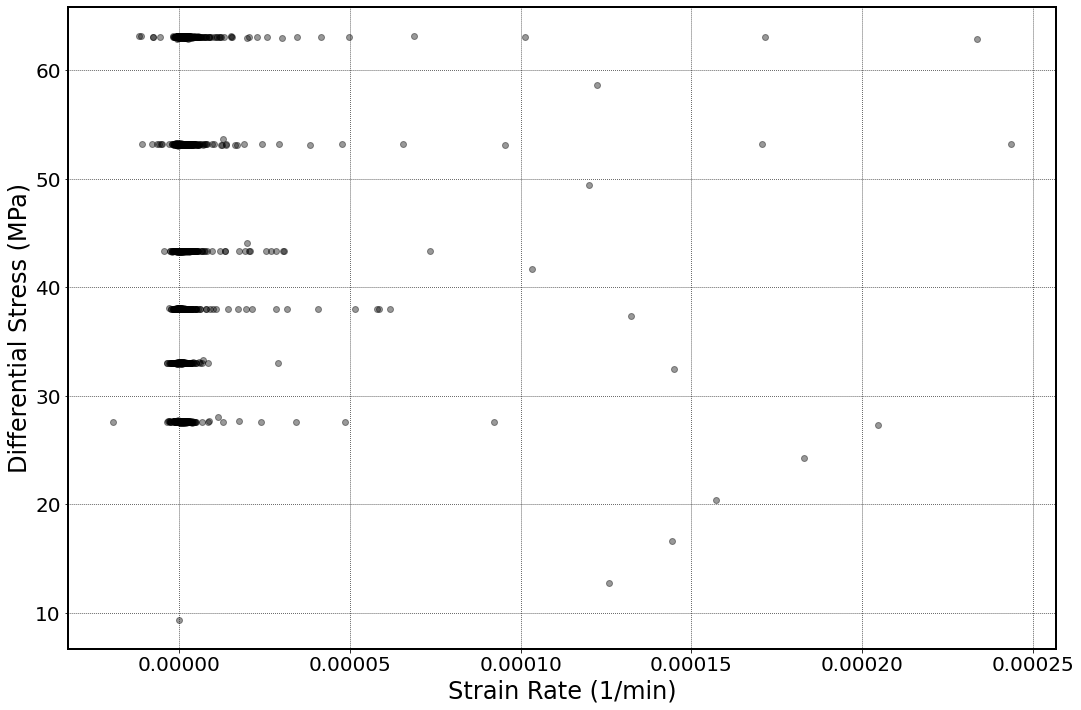

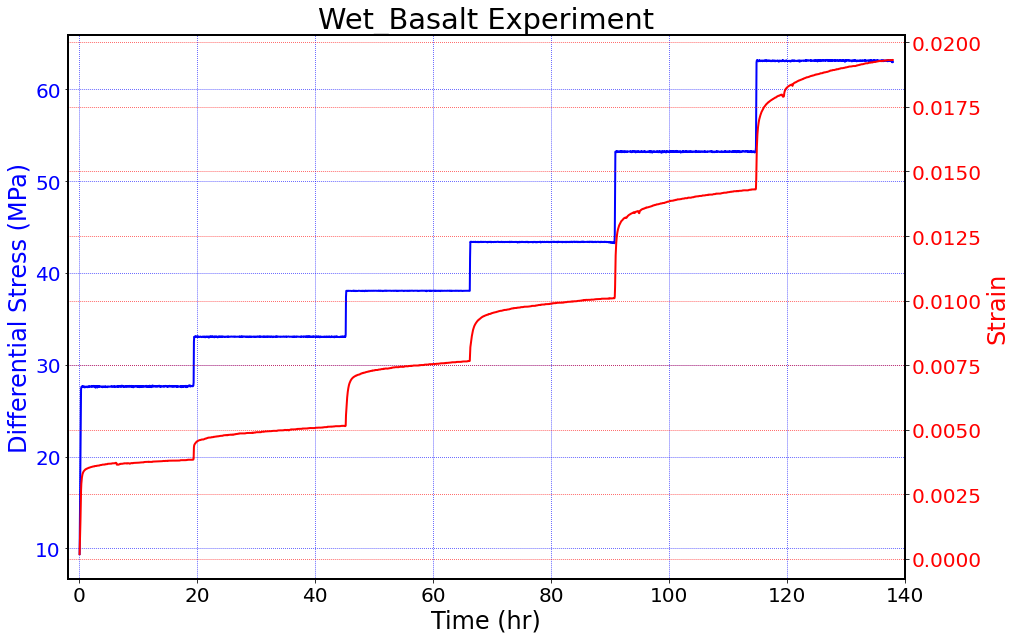

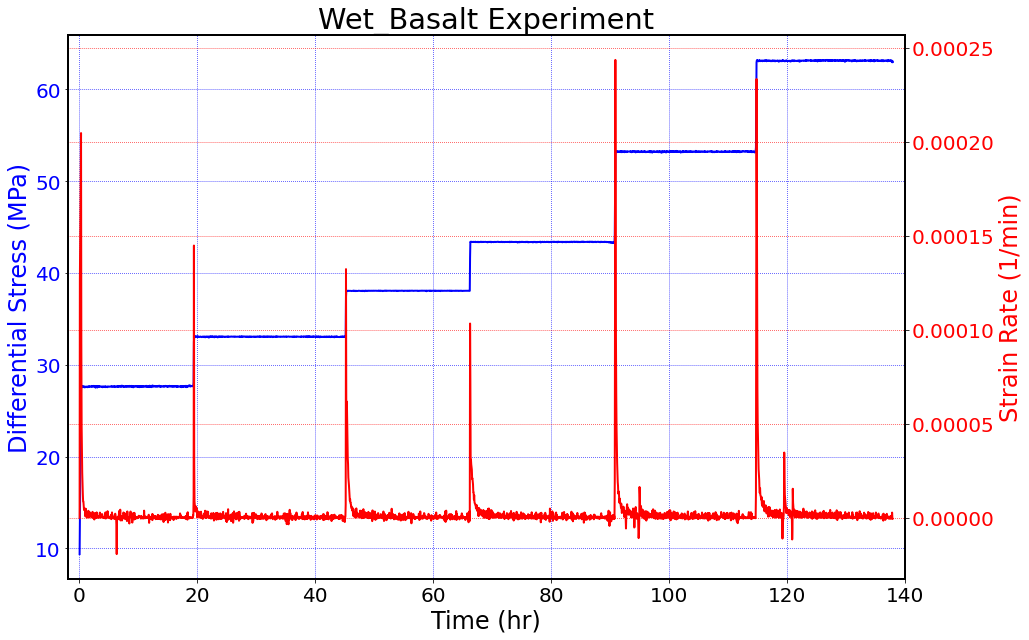

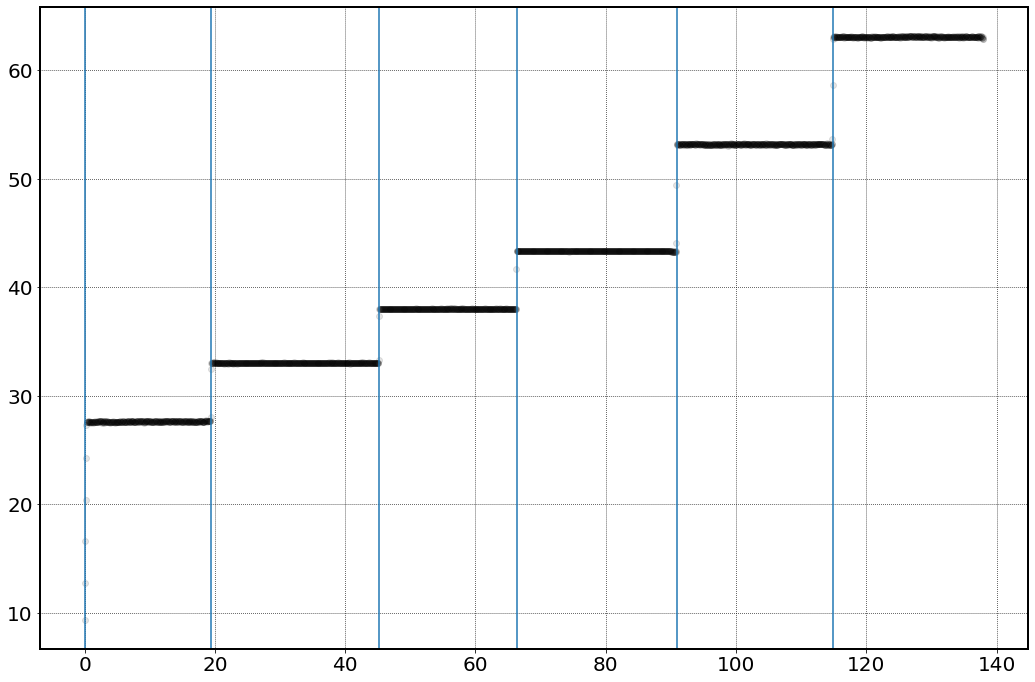

In [25]:
time_window = 180
time_agg = str(int(time_window/60)) + 'min'
new_data_def_Sampl = hbasic.generate_data(new_data,new_data_def,time_window,start_date,end_date)
print(new_data_def_Sampl.columns)
   
new_data_def_Sampl = new_data_def_Sampl.loc[new_data_def_Sampl['time_hr']<=138.,:]
hbasic.make_plots_exp_Dataset(new_data_def_Sampl,name_exp,time_window)

### Finding the steps in the stress based on stress rate
grad_stress = new_data_def_Sampl['stress_rate']
pot_steps = np.where(grad_stress>0.25)[0]
indx = np.hstack([0,np.where(np.diff(new_data_def_Sampl.time_hr[pot_steps])>5)[0],-1])
print('Index value for the stress steps: ' ,pot_steps[indx])
indx = np.hstack([indx[0],indx[2:]])
time_steps = new_data_def_Sampl.time_hr[pot_steps[indx]].reset_index(drop=True)
print('Time(hr) for the stress steps: ',time_steps.values)

plt.figure()
plt.plot(new_data_def_Sampl.time_hr,new_data_def_Sampl.Sig_diff_MPa,'-ko',linewidth=0.1,alpha=0.1)
for k in pot_steps[indx]:
    plt.axvline(x=new_data_def_Sampl.time_hr[k])

    
# import gc
# gc.collect()

scaled_data1 = MinMaxScaler().fit_transform(new_data_def_Sampl)
scaled_data2 = RobustScaler().fit_transform(new_data_def_Sampl)

hbasic.make_file(new_data_def_Sampl,scaled_data1,path_save_file+'MinMax')
hbasic.make_file(new_data_def_Sampl,scaled_data2,path_save_file+'Robust')
del new_data_def_Sampl;

gc.collect()


Index(['Disp_mm', 'Sig_diff_MPa', 'Strain_ax', 't_def', 'Temp', 'time_hr',
       'AE_rate_count', 'strain_rate', 'stress_rate', 'AE_rate_count_rate',
       'Sig_AE_rate', 'strain_rate_AE_rate', 'strain_AE_rate', 'Sig_strain',
       'Sig_strain_rate', 'Strain_strain_rate'],
      dtype='object')
Output_Plots Exists
Output_Plots/Wet_Basalt Exists
Index value for the stress steps:  [   1    4  233  543  796 1091 1379]
Time(hr) for the stress steps:  [8.01388889e-02 1.94134722e+01 4.52468056e+01 6.63301389e+01
 9.09134722e+01 1.14913472e+02]


54711

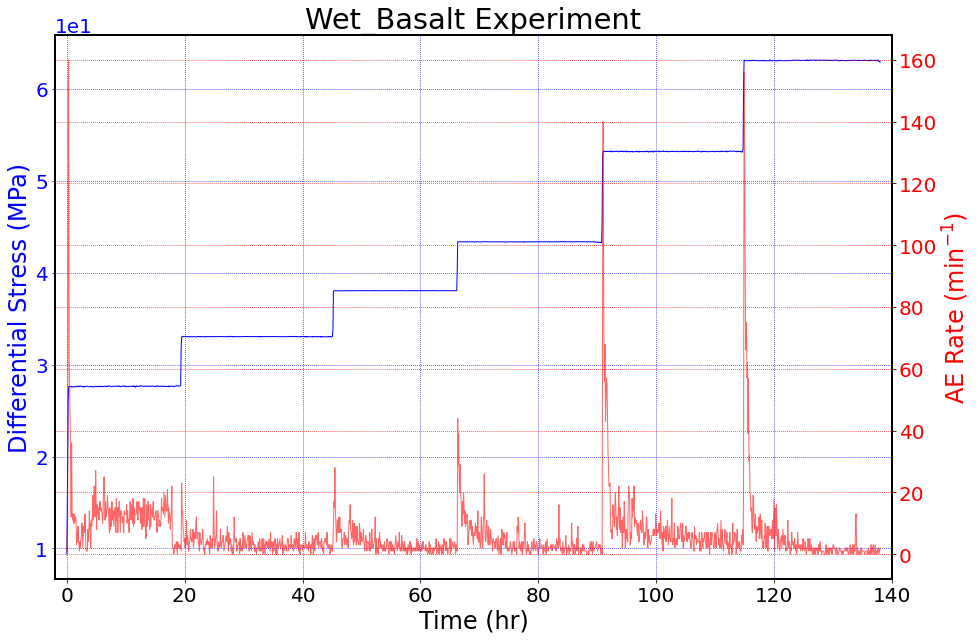

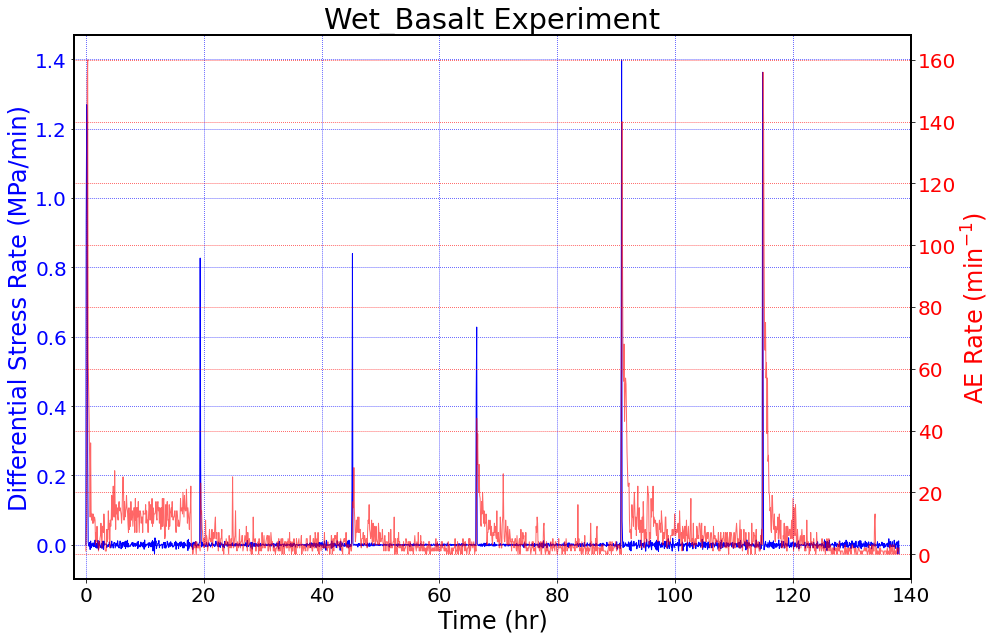

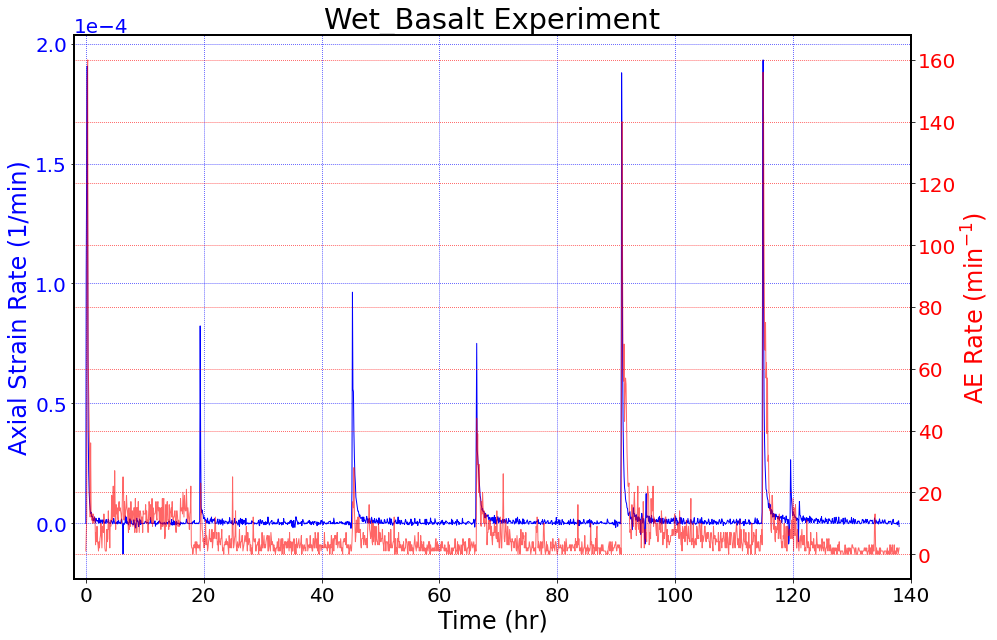

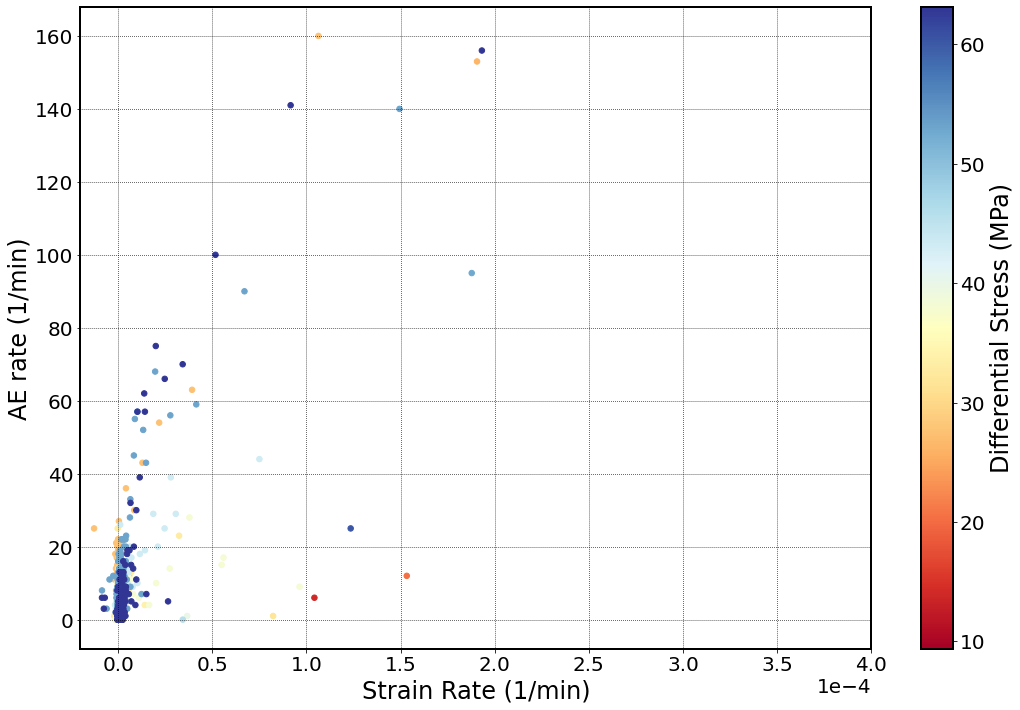

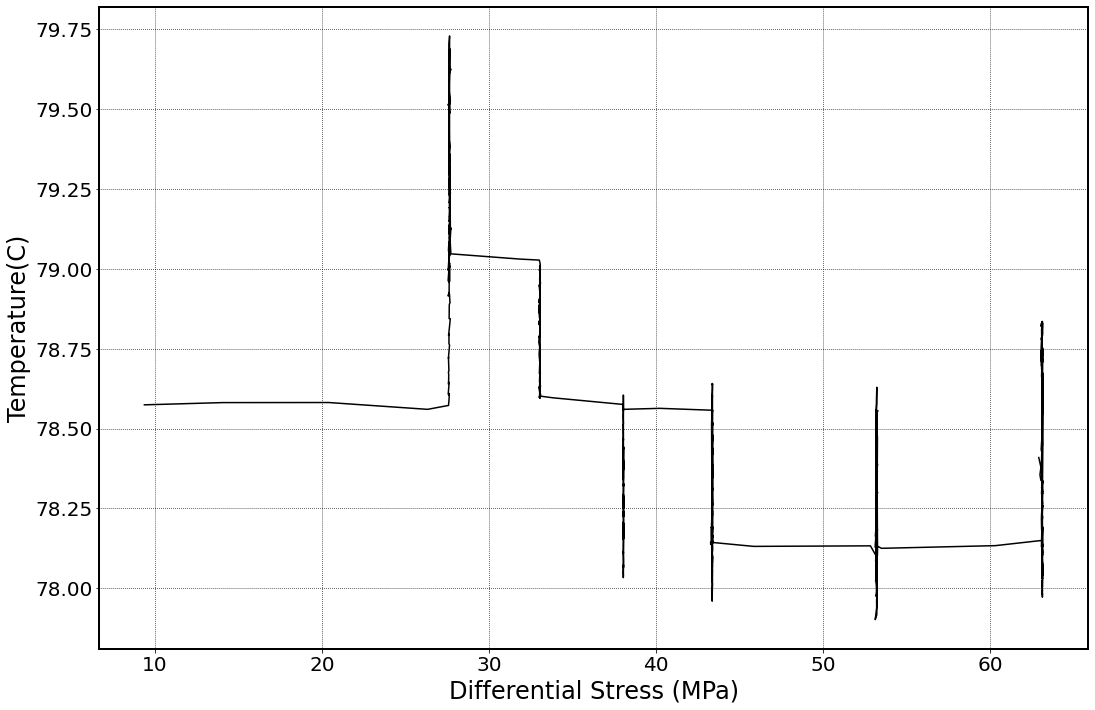

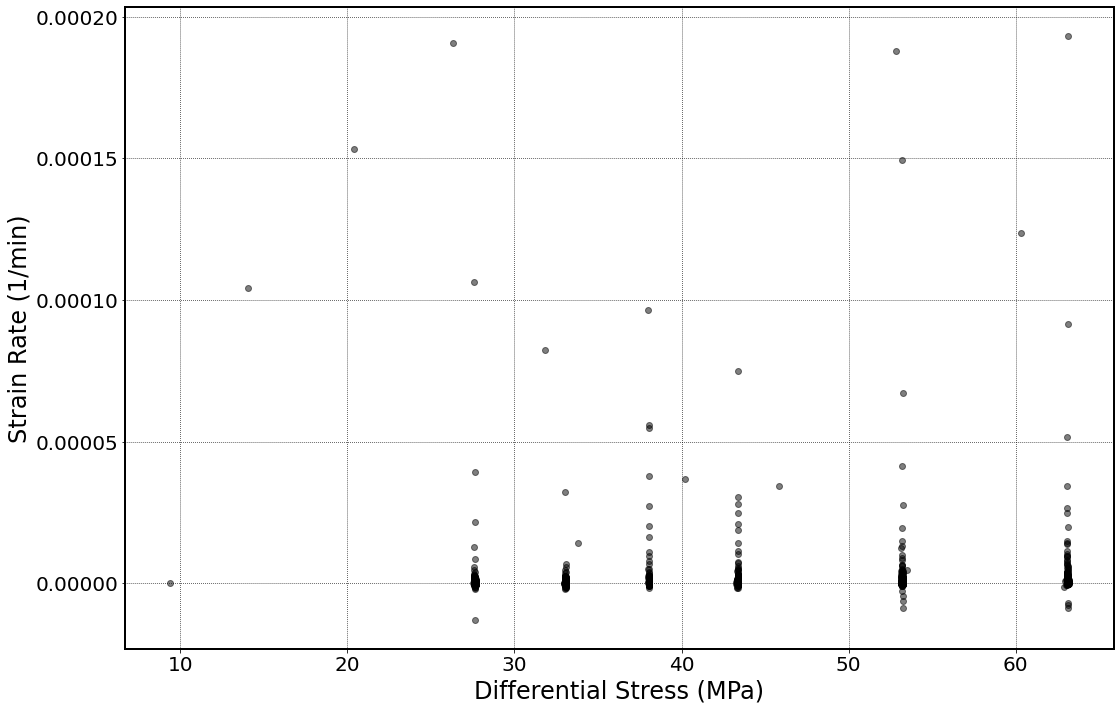

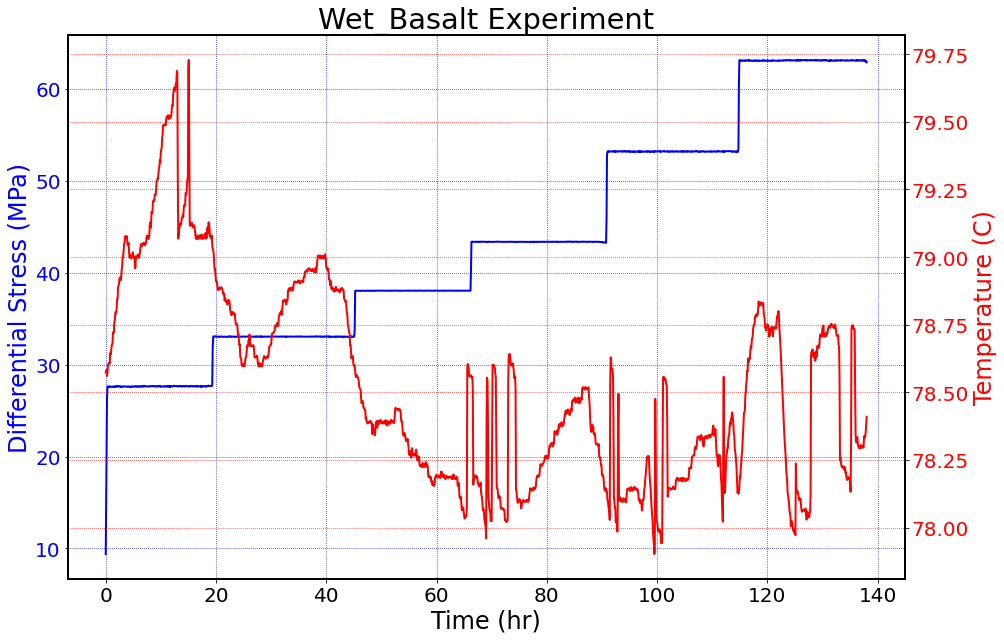

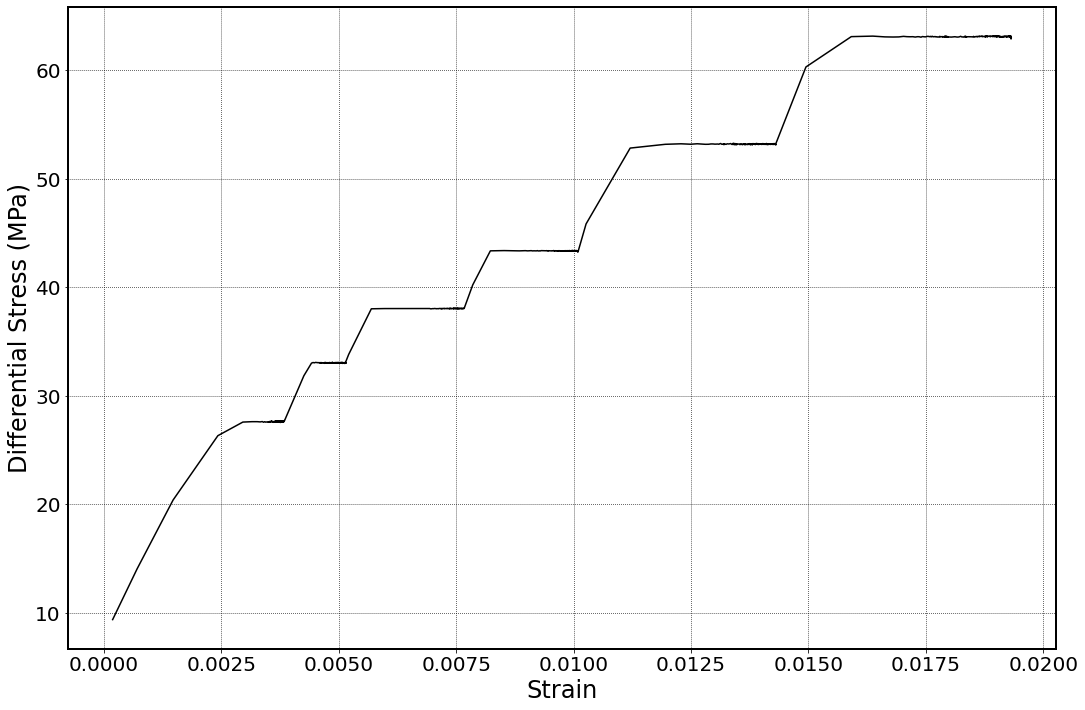

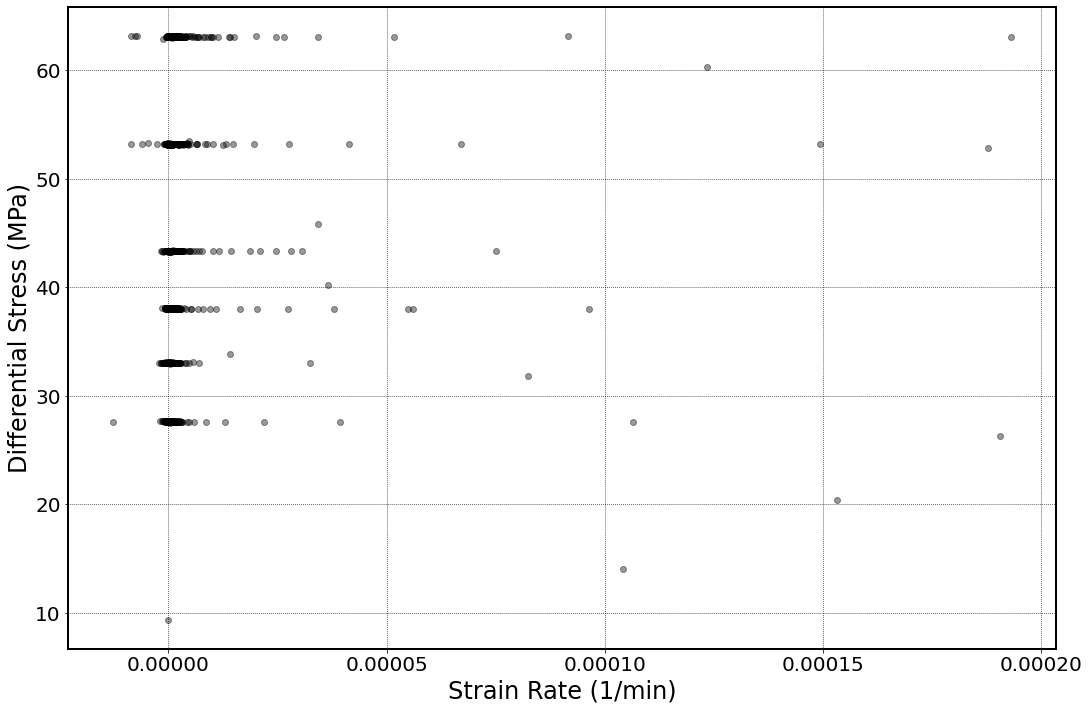

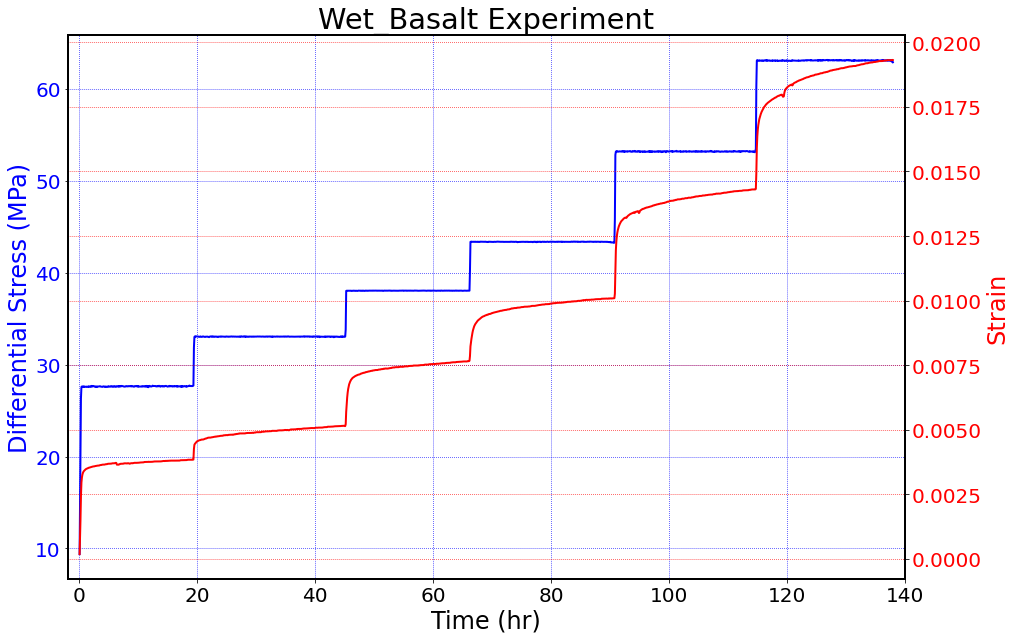

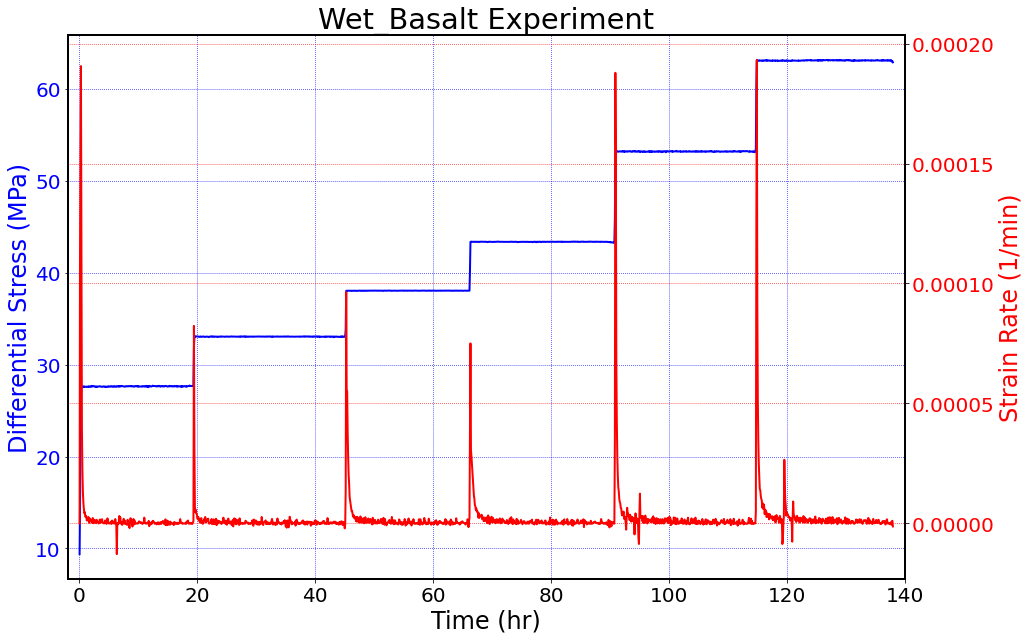

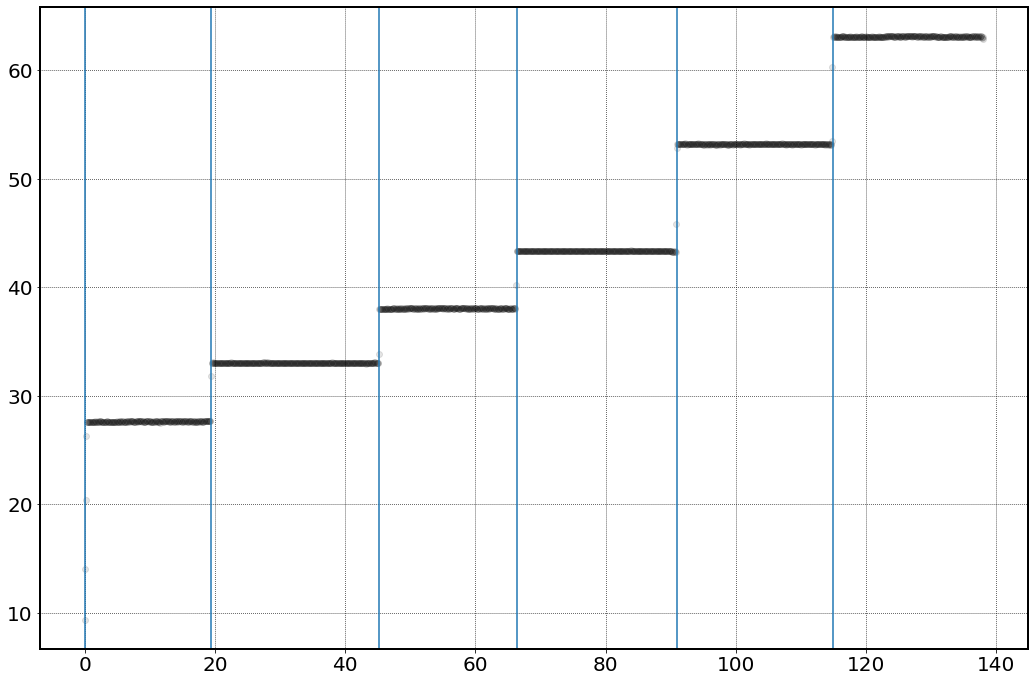

In [26]:
time_window = 300
time_agg = str(int(time_window/60)) + 'min'
new_data_def_Sampl = hbasic.generate_data(new_data,new_data_def,time_window,start_date,end_date)
print(new_data_def_Sampl.columns)
   
new_data_def_Sampl = new_data_def_Sampl.loc[new_data_def_Sampl['time_hr']<=138.,:]
hbasic.make_plots_exp_Dataset(new_data_def_Sampl,name_exp,time_window)

### Finding the steps in the stress based on stress rate
grad_stress = new_data_def_Sampl['stress_rate']
pot_steps = np.where(grad_stress>0.25)[0]
indx = np.hstack([0,np.where(np.diff(new_data_def_Sampl.time_hr[pot_steps])>5)[0],-1])
print('Index value for the stress steps: ' ,pot_steps[indx])
indx = np.hstack([indx[0],indx[2:]])
time_steps = new_data_def_Sampl.time_hr[pot_steps[indx]].reset_index(drop=True)
print('Time(hr) for the stress steps: ',time_steps.values)

plt.figure()
plt.plot(new_data_def_Sampl.time_hr,new_data_def_Sampl.Sig_diff_MPa,'-ko',linewidth=0.1,alpha=0.1)
for k in pot_steps[indx]:
    plt.axvline(x=new_data_def_Sampl.time_hr[k])

    
# import gc
# gc.collect()

scaled_data1 = MinMaxScaler().fit_transform(new_data_def_Sampl)
scaled_data2 = RobustScaler().fit_transform(new_data_def_Sampl)

hbasic.make_file(new_data_def_Sampl,scaled_data1,path_save_file+'MinMax')
hbasic.make_file(new_data_def_Sampl,scaled_data2,path_save_file+'Robust')
del new_data_def_Sampl;

gc.collect()


Index(['Disp_mm', 'Sig_diff_MPa', 'Strain_ax', 't_def', 'Temp', 'time_hr',
       'AE_rate_count', 'strain_rate', 'stress_rate', 'AE_rate_count_rate',
       'Sig_AE_rate', 'strain_rate_AE_rate', 'strain_AE_rate', 'Sig_strain',
       'Sig_strain_rate', 'Strain_strain_rate'],
      dtype='object')
Output_Plots Exists
Output_Plots/Wet_Basalt Exists
Index value for the stress steps:  [  1   2 117 271 398 546 689]
Time(hr) for the stress steps:  [  0.20513889  19.53847222  45.20513889  66.37180556  91.03847222
 114.87180556]


55036

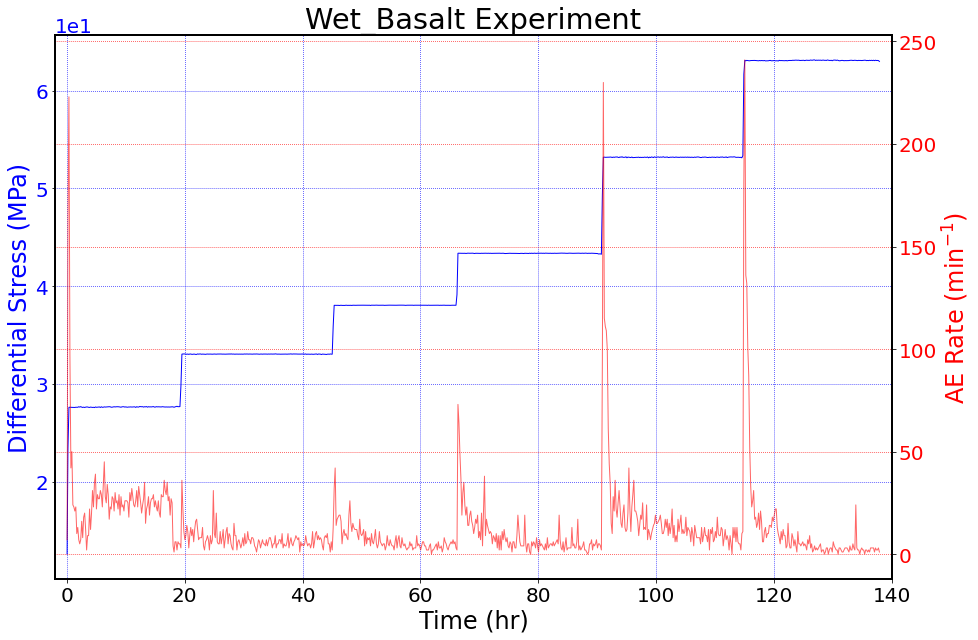

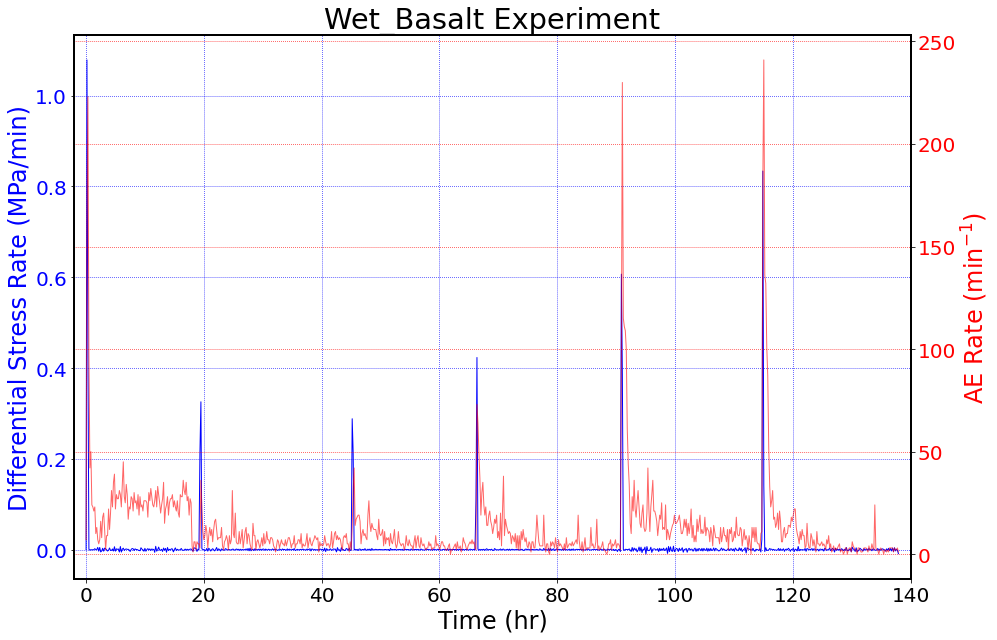

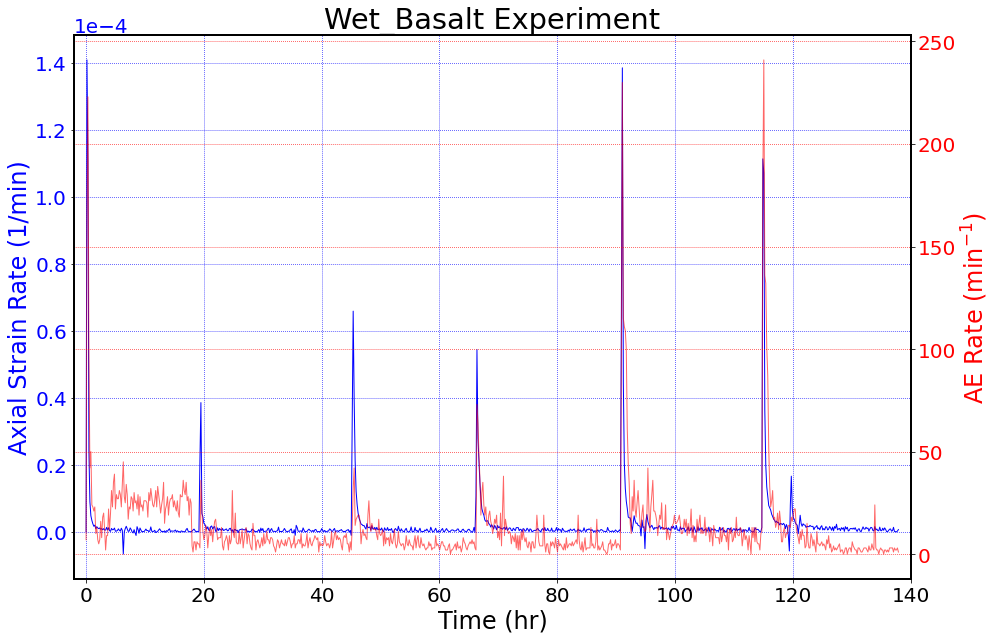

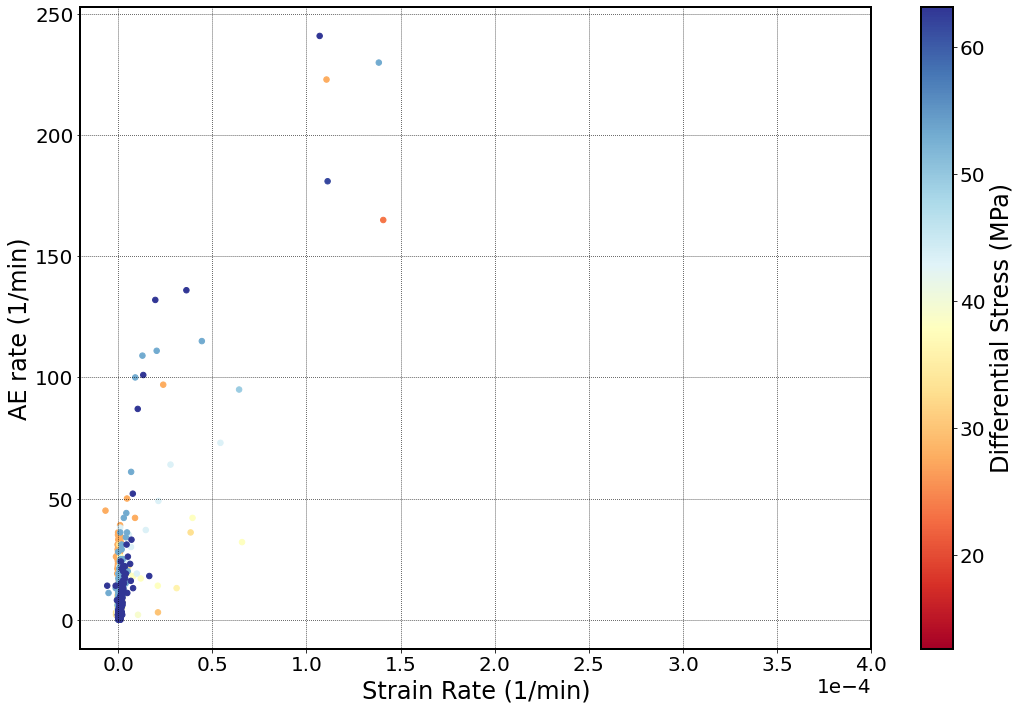

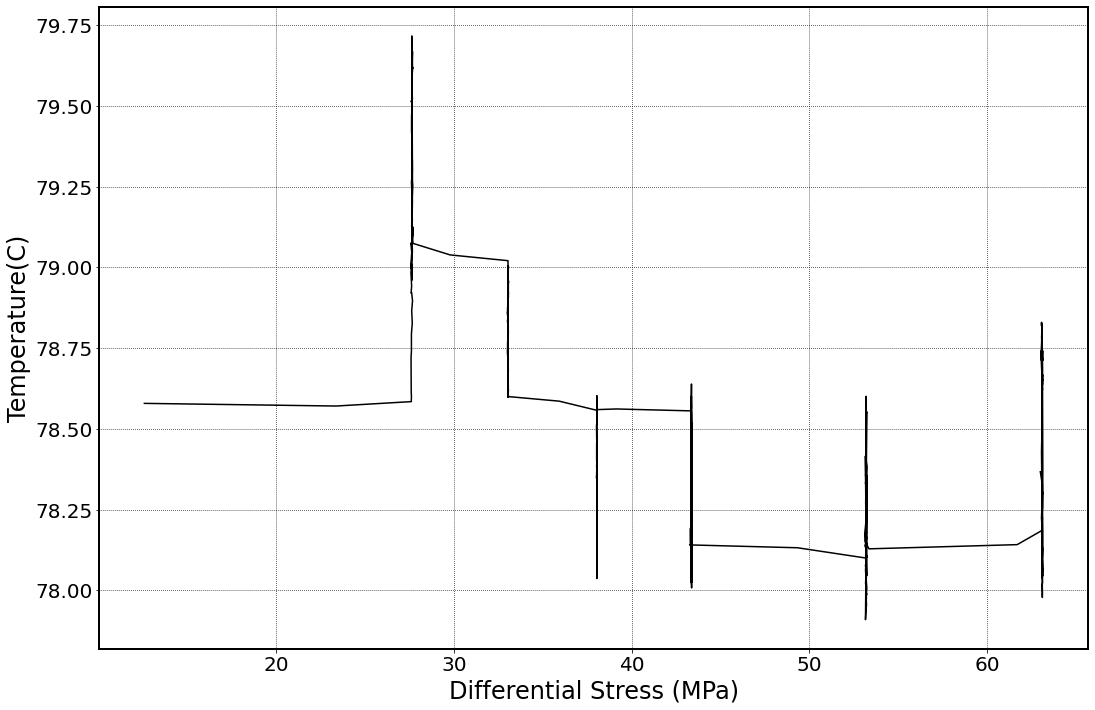

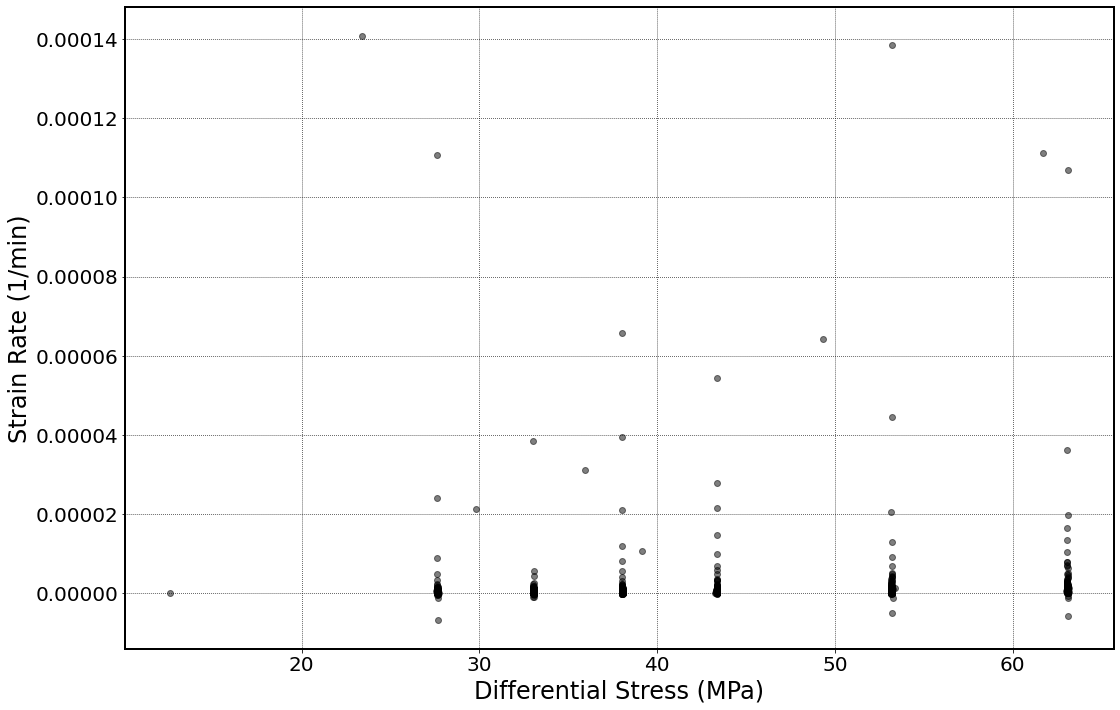

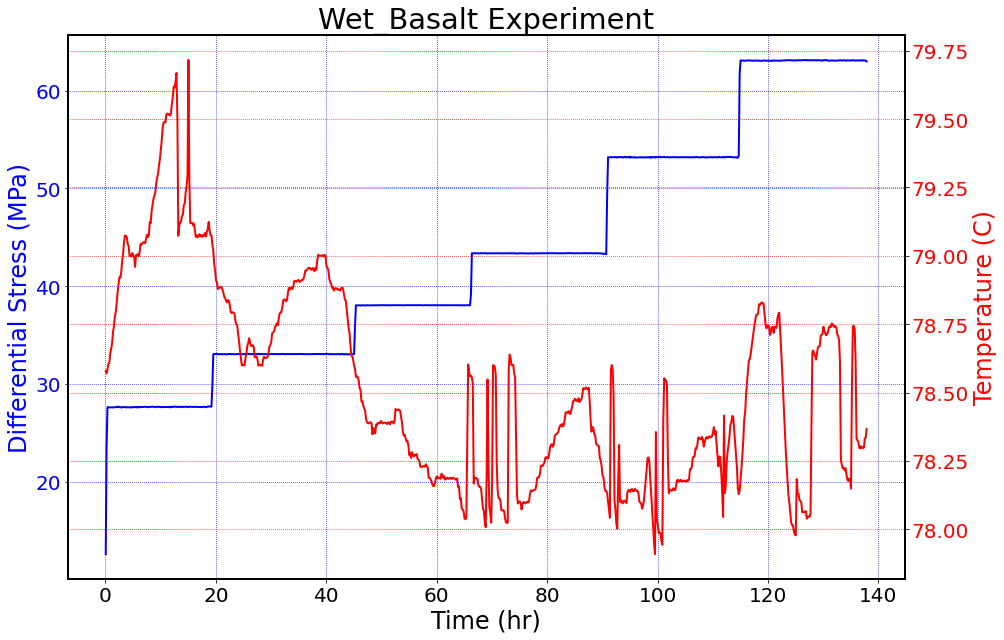

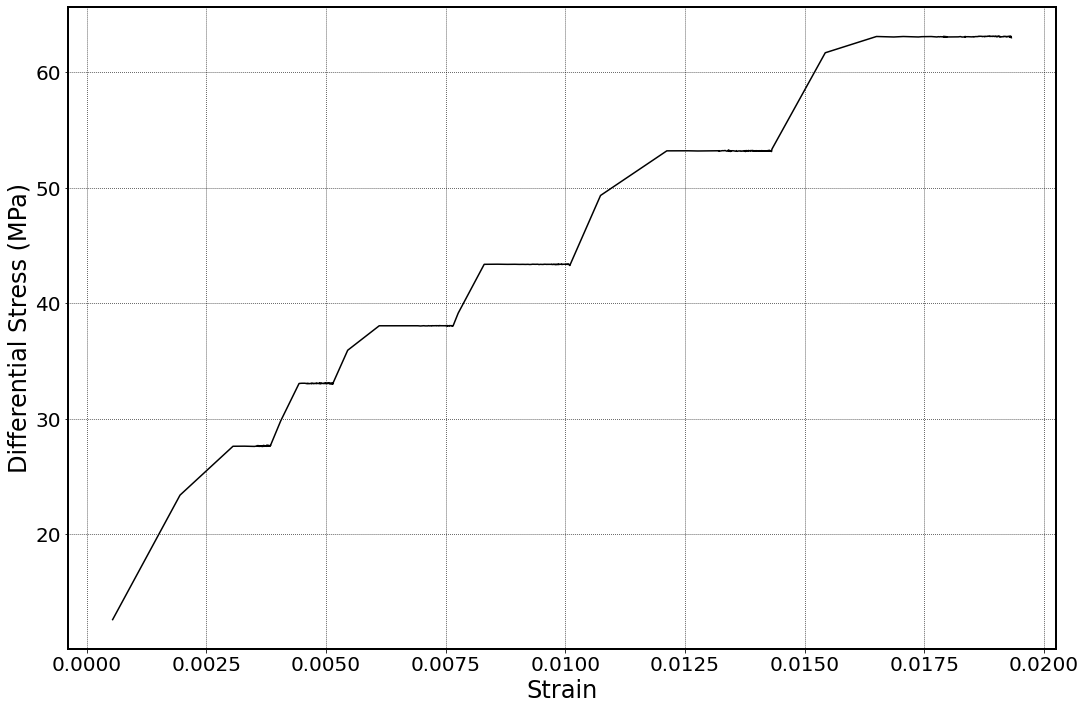

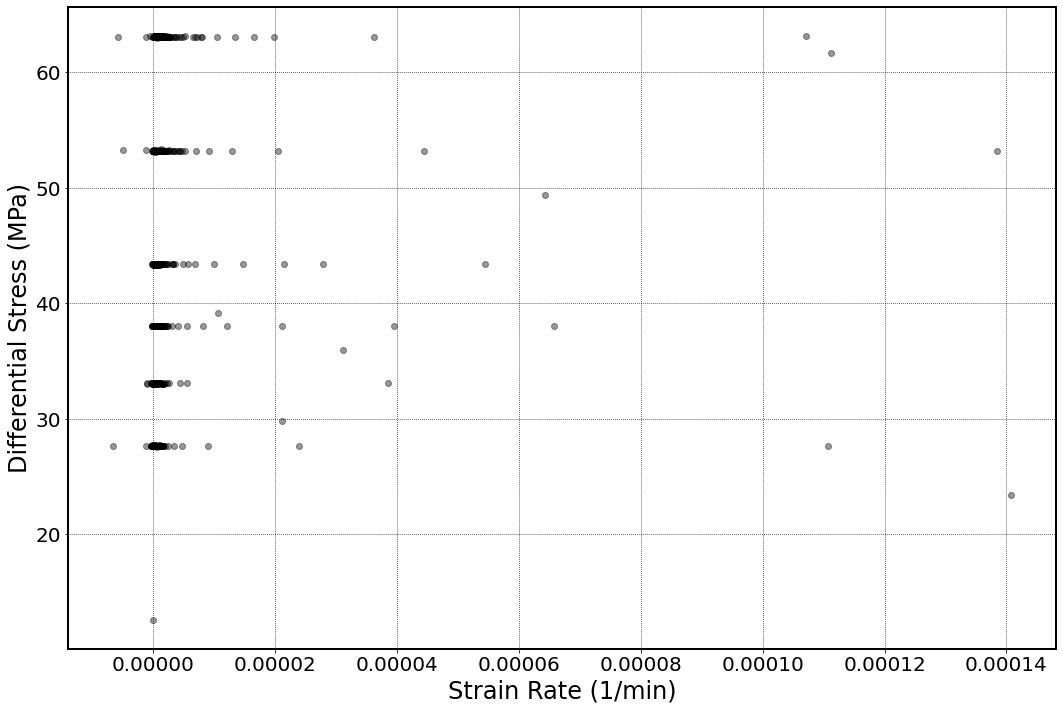

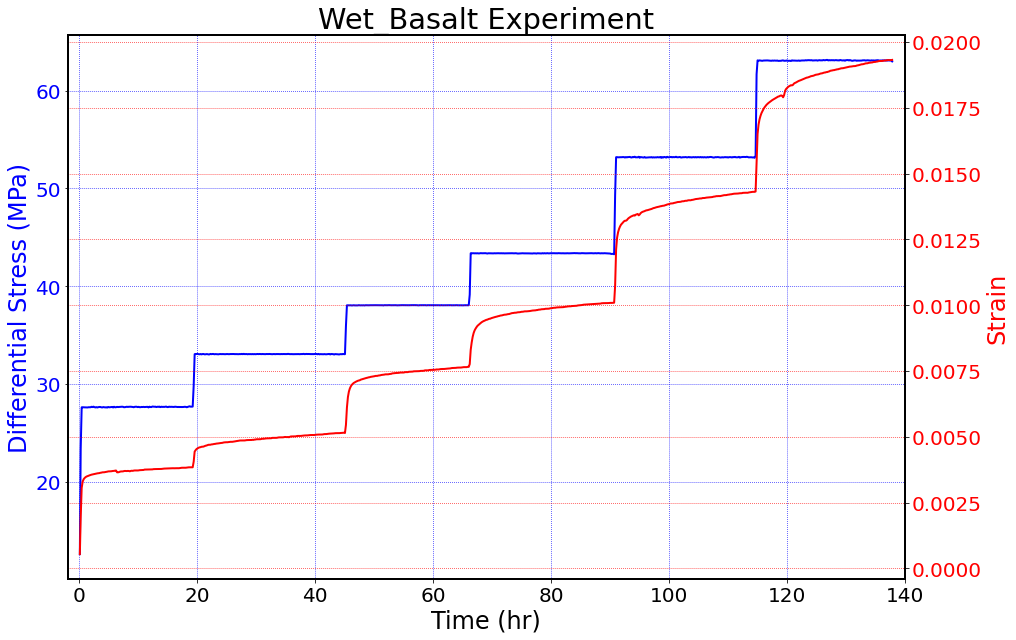

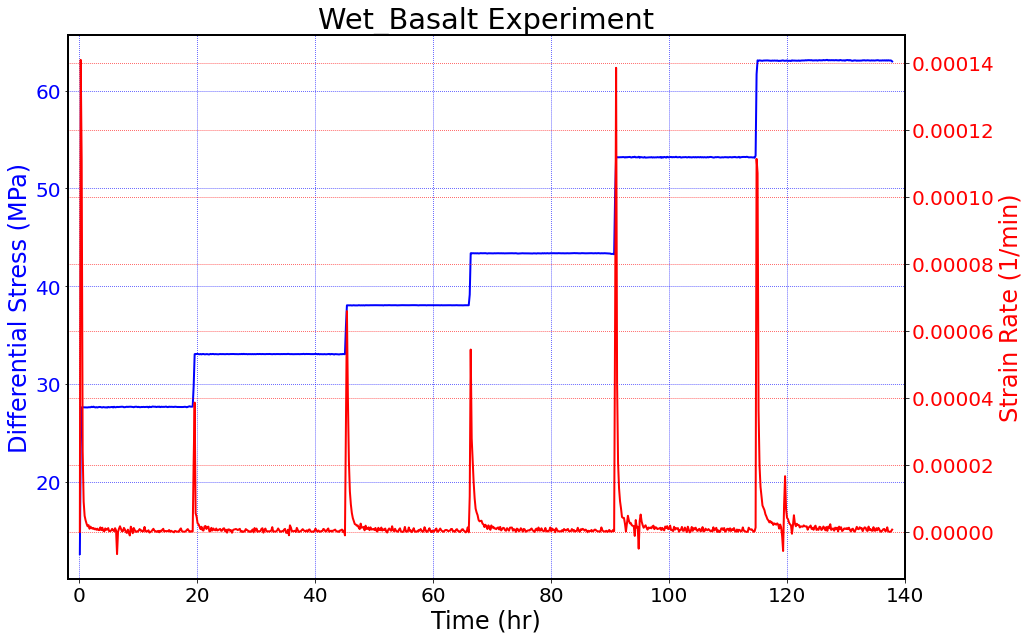

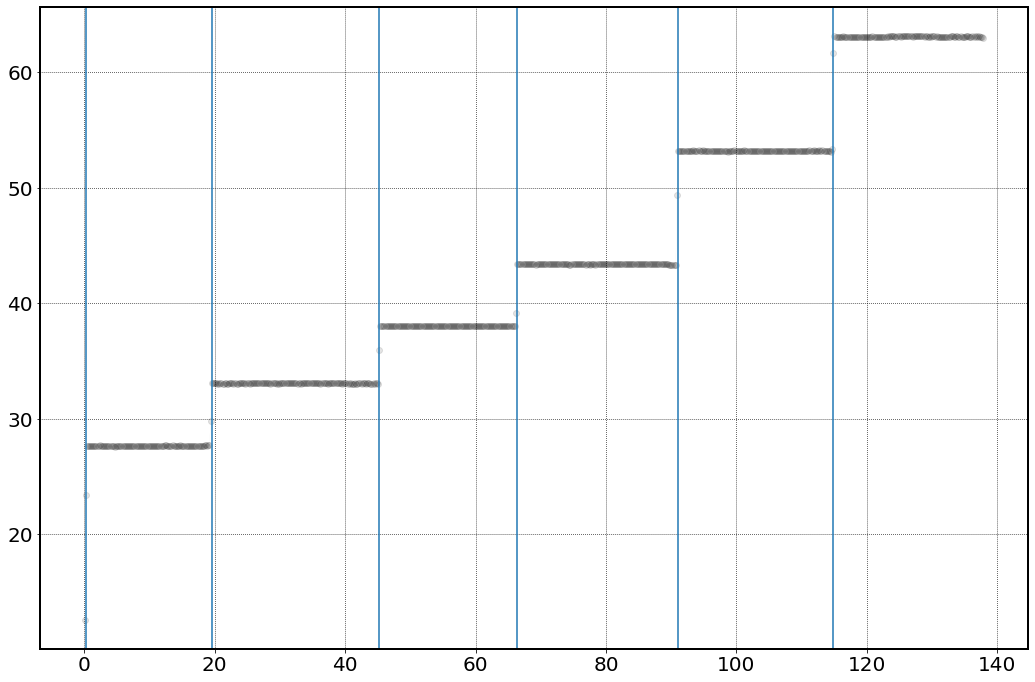

In [27]:
time_window = 600
time_agg = str(int(time_window/60)) + 'min'
new_data_def_Sampl = hbasic.generate_data(new_data,new_data_def,time_window,start_date,end_date)
print(new_data_def_Sampl.columns)
   
new_data_def_Sampl = new_data_def_Sampl.loc[new_data_def_Sampl['time_hr']<=138.,:]
hbasic.make_plots_exp_Dataset(new_data_def_Sampl,name_exp,time_window)

### Finding the steps in the stress based on stress rate
grad_stress = new_data_def_Sampl['stress_rate']
pot_steps = np.where(grad_stress>0.25)[0]
indx = np.hstack([0,np.where(np.diff(new_data_def_Sampl.time_hr[pot_steps])>5)[0],-1])
print('Index value for the stress steps: ' ,pot_steps[indx])
indx = np.hstack([indx[0],indx[2:]])
time_steps = new_data_def_Sampl.time_hr[pot_steps[indx]].reset_index(drop=True)
print('Time(hr) for the stress steps: ',time_steps.values)

plt.figure()
plt.plot(new_data_def_Sampl.time_hr,new_data_def_Sampl.Sig_diff_MPa,'-ko',linewidth=0.1,alpha=0.1)
for k in pot_steps[indx]:
    plt.axvline(x=new_data_def_Sampl.time_hr[k])

    
# import gc
# gc.collect()

scaled_data1 = MinMaxScaler().fit_transform(new_data_def_Sampl)
scaled_data2 = RobustScaler().fit_transform(new_data_def_Sampl)

hbasic.make_file(new_data_def_Sampl,scaled_data1,path_save_file+'MinMax')
hbasic.make_file(new_data_def_Sampl,scaled_data2,path_save_file+'Robust')
del new_data_def_Sampl;

gc.collect()
